In [3]:
import polars as pl
import glob
import os

# ============================================================
# 1. 파일 필터링 (202412 ~ 202511)
# ============================================================
files = sorted(glob.glob("../food/*.parquet"))

target_files = []

for f in files:
    for ym in range(202412, 202512):
        if str(ym) in f:
            target_files.append(f)
            break

print(f"사용 파일 수: {len(target_files)}")

# ============================================================
# 2. Lazy Scan (컬럼은 select로 제한)
# ============================================================
lf = (
    pl.scan_parquet(target_files)
      .select(["card_tpbuz_nm_2", "amt", "cnt"])
)

# ============================================================
# 3. 전체 기간 카테고리별 합계
# ============================================================
df_overall = (
    lf.group_by("card_tpbuz_nm_2")
      .agg([
          pl.col("amt").sum().alias("amt"),
          pl.col("cnt").sum().alias("cnt")
      ])
      .sort("amt", descending=True)
      .collect()
)

# ============================================================
# 4. 저장
# ============================================================
OUTPUT_DIR = "../output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_overall.write_csv(
    f"{OUTPUT_DIR}/overall_category_summary_202412_202511.csv"
)

df_overall.write_parquet(
    f"{OUTPUT_DIR}/overall_category_summary_202412_202511.parquet"
)

print("✅ 집계 완료 및 저장 성공")


사용 파일 수: 12
✅ 집계 완료 및 저장 성공


In [7]:
import polars as pl
import glob
import os

# ============================================================
# 1. 월별 parquet 파일 목록
# ============================================================
DATA_PATH = "../food/*.parquet"
files = sorted(glob.glob(DATA_PATH))

# 🔥 필요 시 최근 1년만 필터
target_files = []

for f in files:
    for ym in range(202412, 202512):
        if str(ym) in f:
            target_files.append(f)
            break

# ============================================================
# 2. Lazy Scan + year_month 생성 (파일명 기준)
# ============================================================
lf = pl.scan_parquet(target_files)

# 파일명에서 year_month 추출
lf = lf.with_columns(
    pl.element()
      .map_elements(lambda _: None)
      .alias("year_month")
)

# Polars에서는 파일명 직접 접근이 안 되므로
# 👉 파일별로 LazyFrame 만들어 union 하는 방식이 가장 안전
lazy_frames = []

for f in target_files:
    ym = os.path.basename(f).replace(".parquet", "")
    
    lfi = (
        pl.scan_parquet(f)
          .select(["card_tpbuz_nm_2", "amt", "cnt"])
          .with_columns(pl.lit(ym).alias("year_month"))
    )
    lazy_frames.append(lfi)

lf_all = pl.concat(lazy_frames)

# ============================================================
# 3. 월별 × 카테고리 집계
# ============================================================
df_monthly = (
    lf_all.group_by(["year_month", "card_tpbuz_nm_2"])
          .agg([
              pl.col("amt").sum().alias("amt"),
              pl.col("cnt").sum().alias("cnt")
          ])
          .sort(["year_month", "amt"], descending=[False, True])
          .collect()
)

print(df_monthly.head())


shape: (5, 4)
┌────────────┬─────────────────┬──────────────┬──────────┐
│ year_month ┆ card_tpbuz_nm_2 ┆ amt          ┆ cnt      │
│ ---        ┆ ---             ┆ ---          ┆ ---      │
│ str        ┆ str             ┆ i64          ┆ i64      │
╞════════════╪═════════════════╪══════════════╪══════════╡
│ 202412     ┆ 한식            ┆ 322037899077 ┆ 9452544  │
│ 202412     ┆ 고기요리        ┆ 159673603112 ┆ 3249350  │
│ 202412     ┆ 디저트/음료     ┆ 153225994063 ┆ 14330232 │
│ 202412     ┆ 일식/수산물     ┆ 101485544133 ┆ 1815717  │
│ 202412     ┆ 별식/퓨전요리   ┆ 54897471682  ┆ 2002555  │
└────────────┴─────────────────┴──────────────┴──────────┘


In [8]:
OUTPUT_DIR = "../output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

df_monthly.write_csv(
    f"{OUTPUT_DIR}/category_monthly_summary_202412_202511.csv"
)

df_monthly.write_parquet(
    f"{OUTPUT_DIR}/category_monthly_summary_202412_202511.parquet"
)


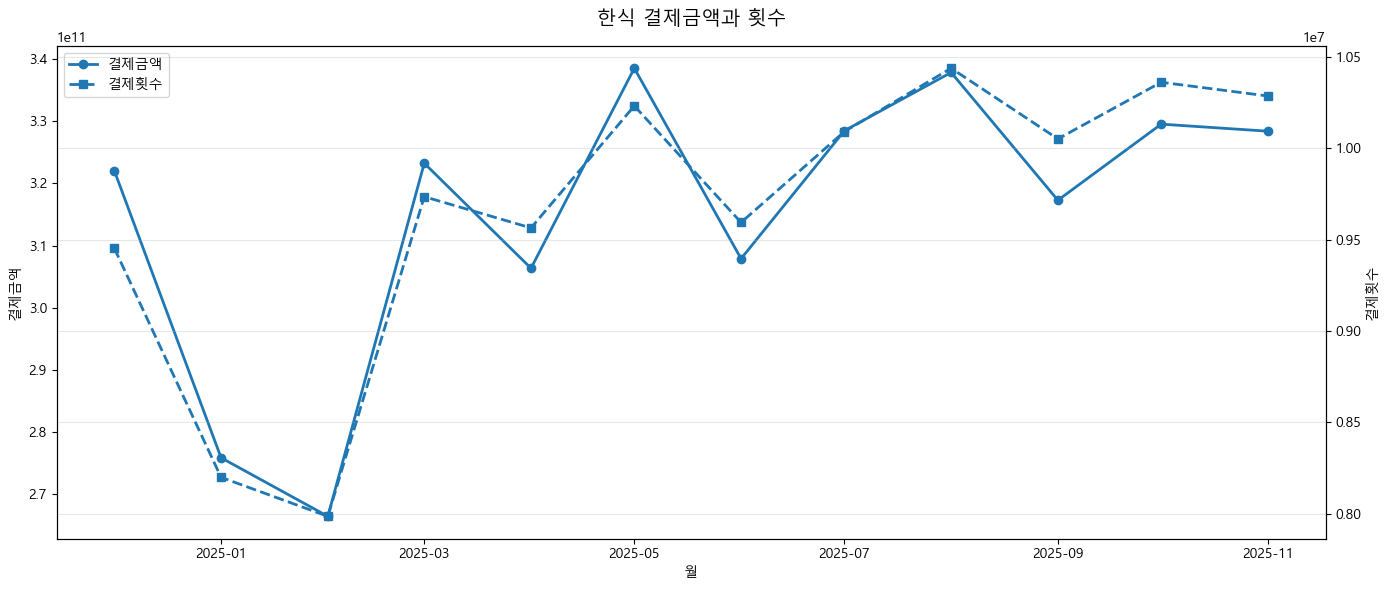

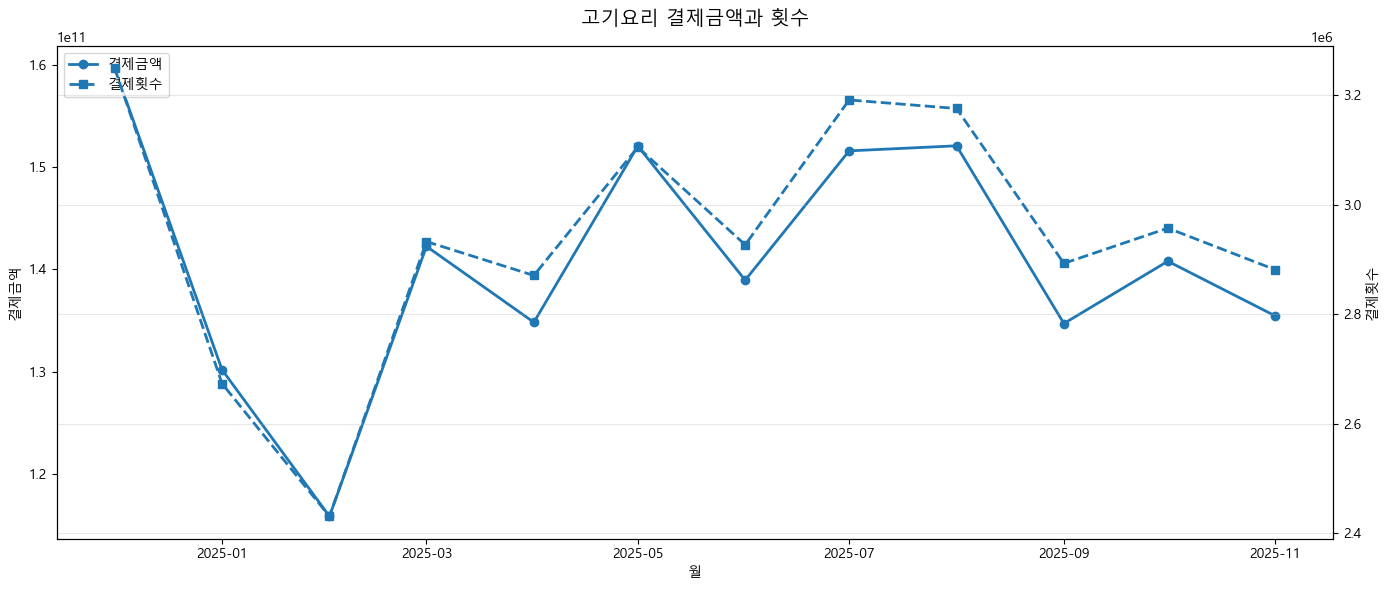

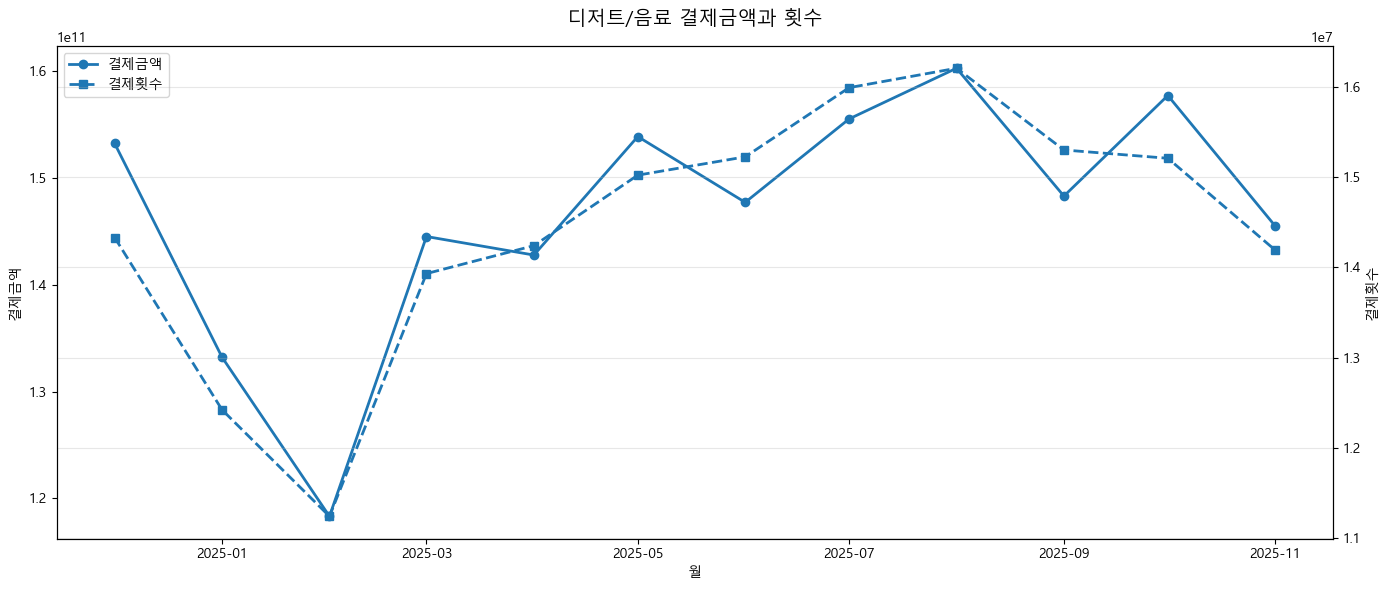

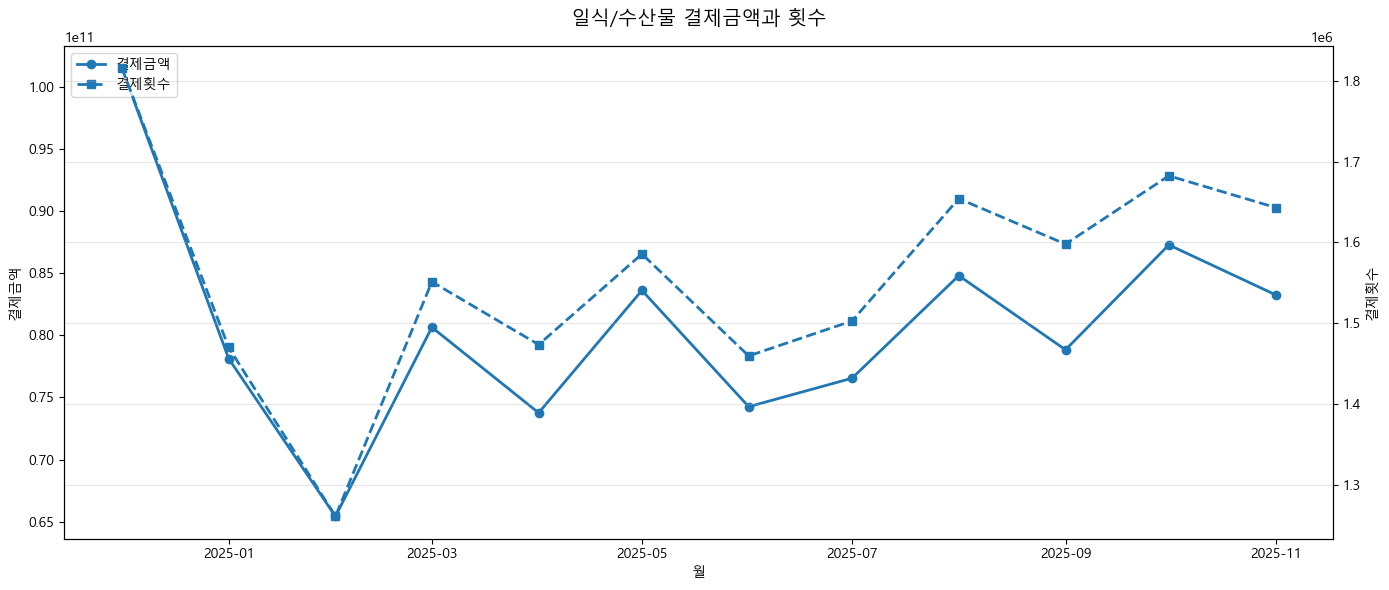

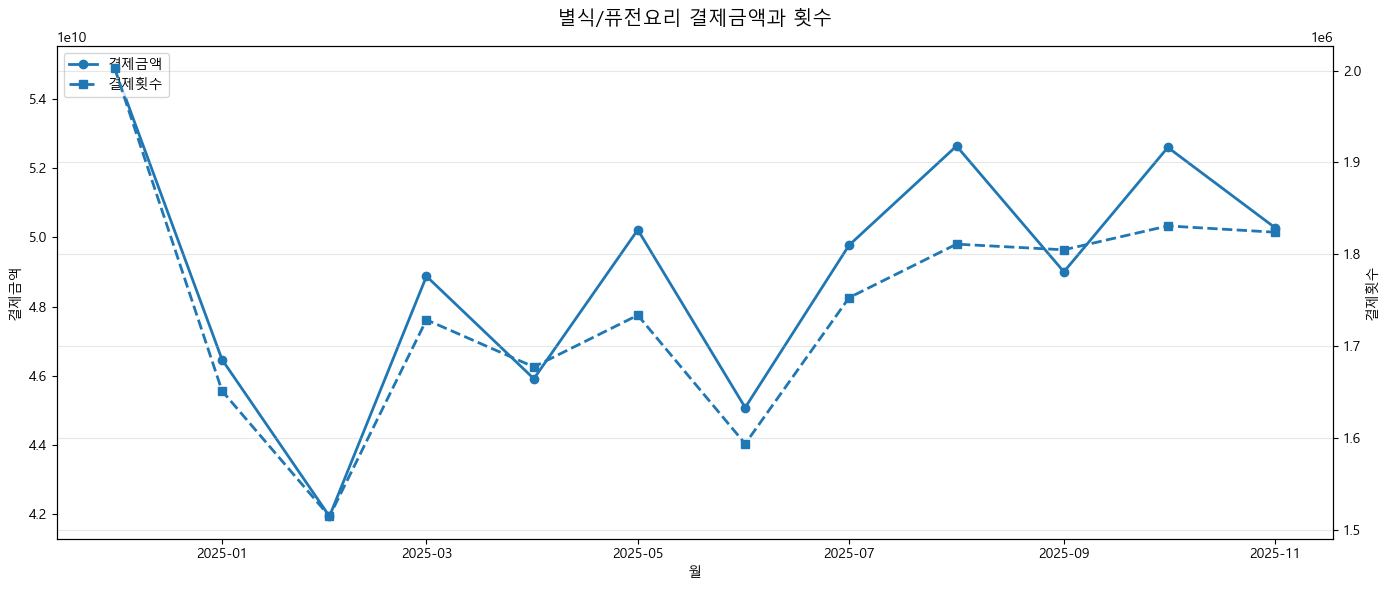

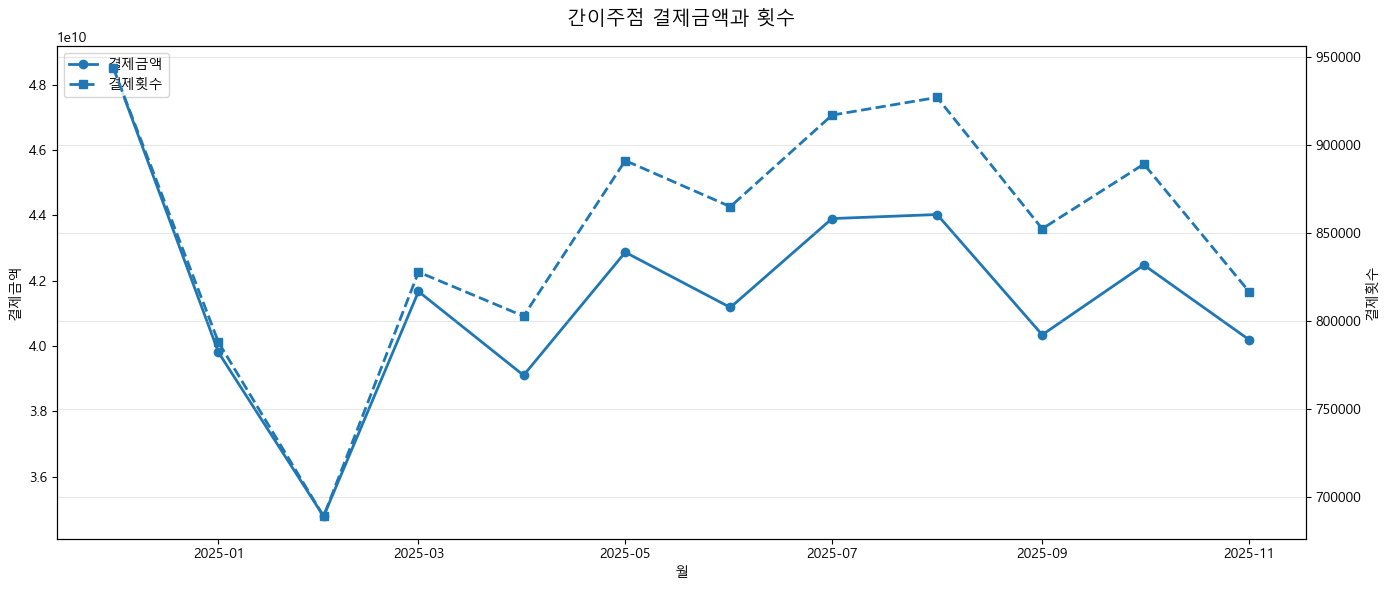

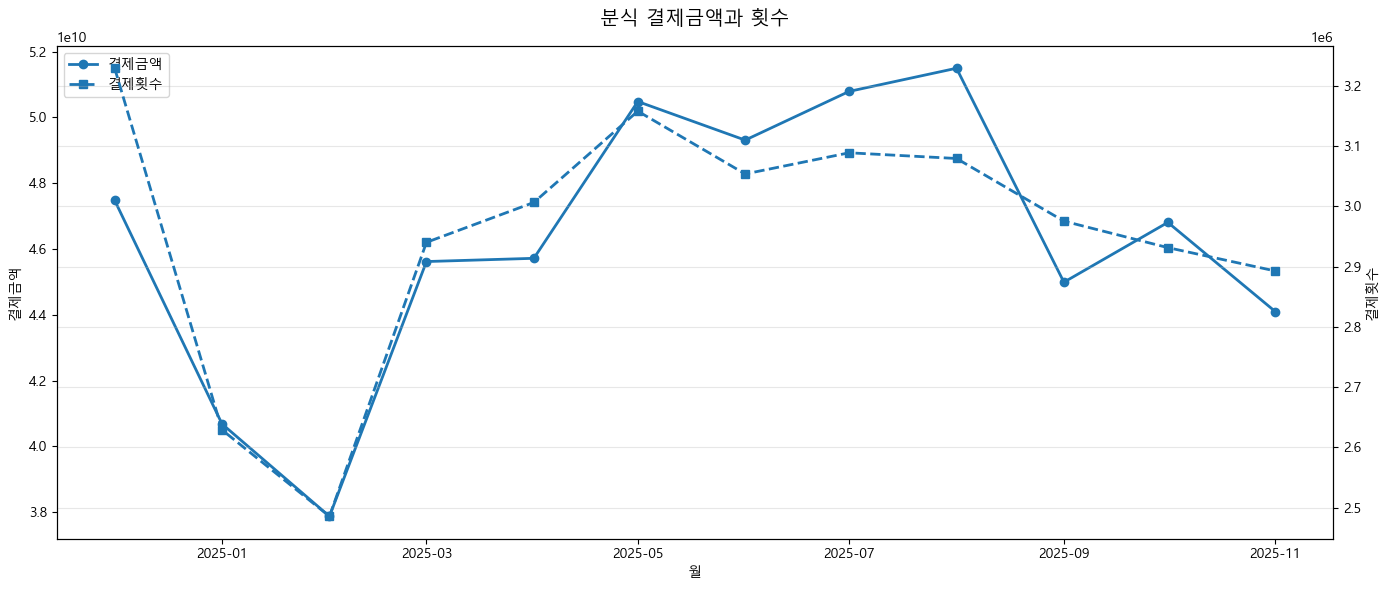

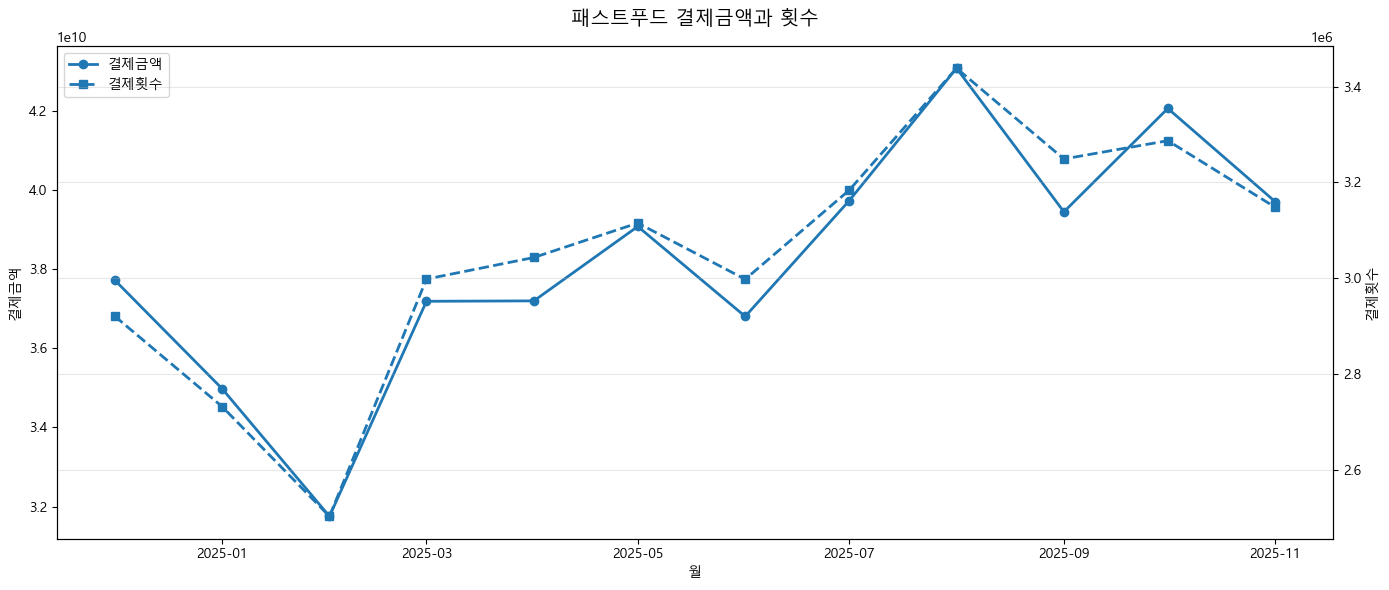

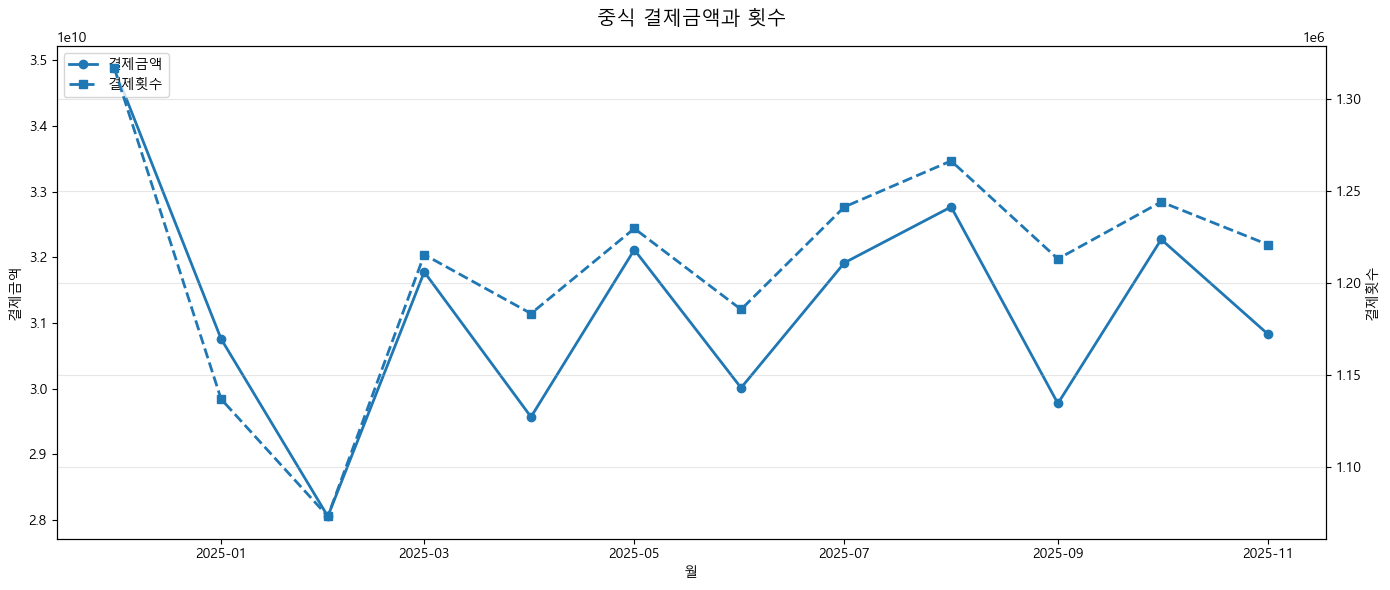

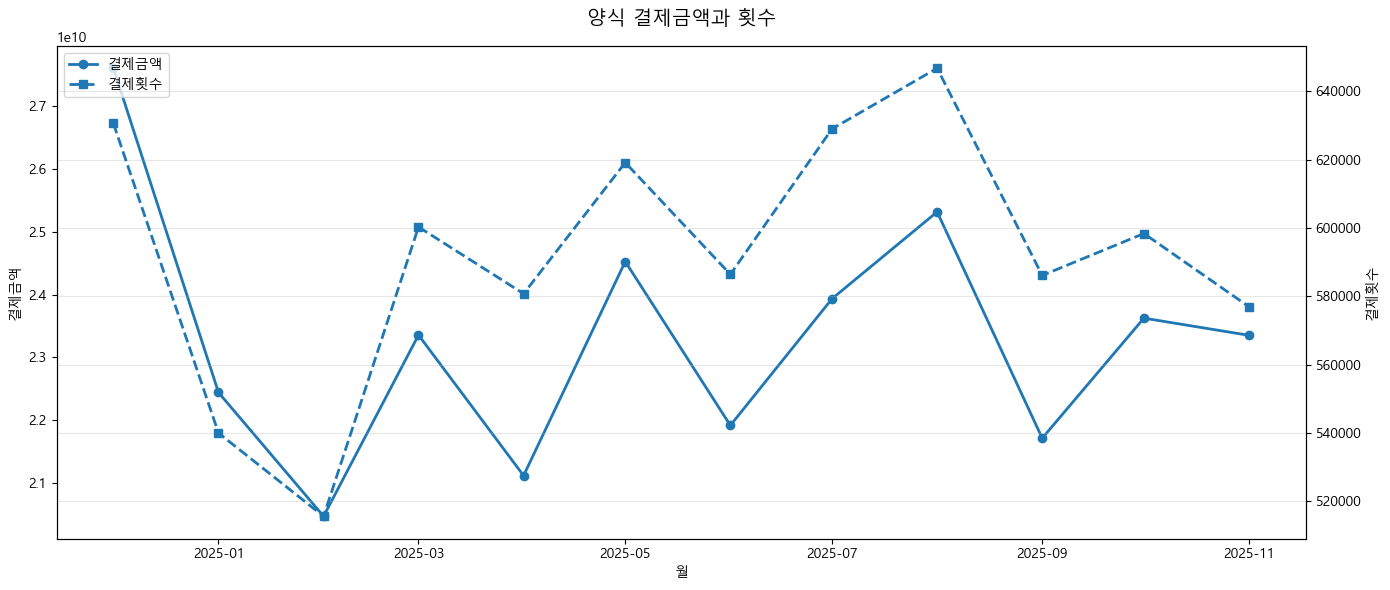

In [13]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ============================================================
# 한글 폰트 설정 (Windows)
# ============================================================
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# ============================================================
# Parquet 데이터 읽기
# ============================================================
df = pd.read_parquet(
    "../output/category_monthly_summary_202412_202511.parquet"
)

# ============================================================
# YYYYMM → datetime (월 단위)
# ============================================================
df['year_month'] = pd.to_datetime(
    df['year_month'].astype(str),
    format='%Y%m'
)

df = df.sort_values('year_month')

# ============================================================
# 카테고리별 이중 축 시계열 그래프
# ============================================================
categories = df['card_tpbuz_nm_2'].unique()

for category in categories:
    sub = df[df['card_tpbuz_nm_2'] == category]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # ------------------------------
    # 결제금액 (좌측 y축)
    # ------------------------------
    line1 = ax1.plot(
        sub['year_month'],
        sub['amt'],
        marker='o',
        linewidth=2,
        label='결제금액'
    )
    ax1.set_ylabel('결제금액')
    ax1.set_xlabel('월')

    # ------------------------------
    # 결제횟수 (우측 y축)
    # ------------------------------
    ax2 = ax1.twinx()
    line2 = ax2.plot(
        sub['year_month'],
        sub['cnt'],
        marker='s',
        linestyle='--',
        linewidth=2,
        label='결제횟수'
    )
    ax2.set_ylabel('결제횟수')

    # ------------------------------
    # 제목 및 범례
    # ------------------------------
    plt.title(f"{category} 결제금액과 횟수", fontsize=14, pad=15)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')

    # ------------------------------
    # 가독성 옵션
    # ------------------------------
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    plt.show()


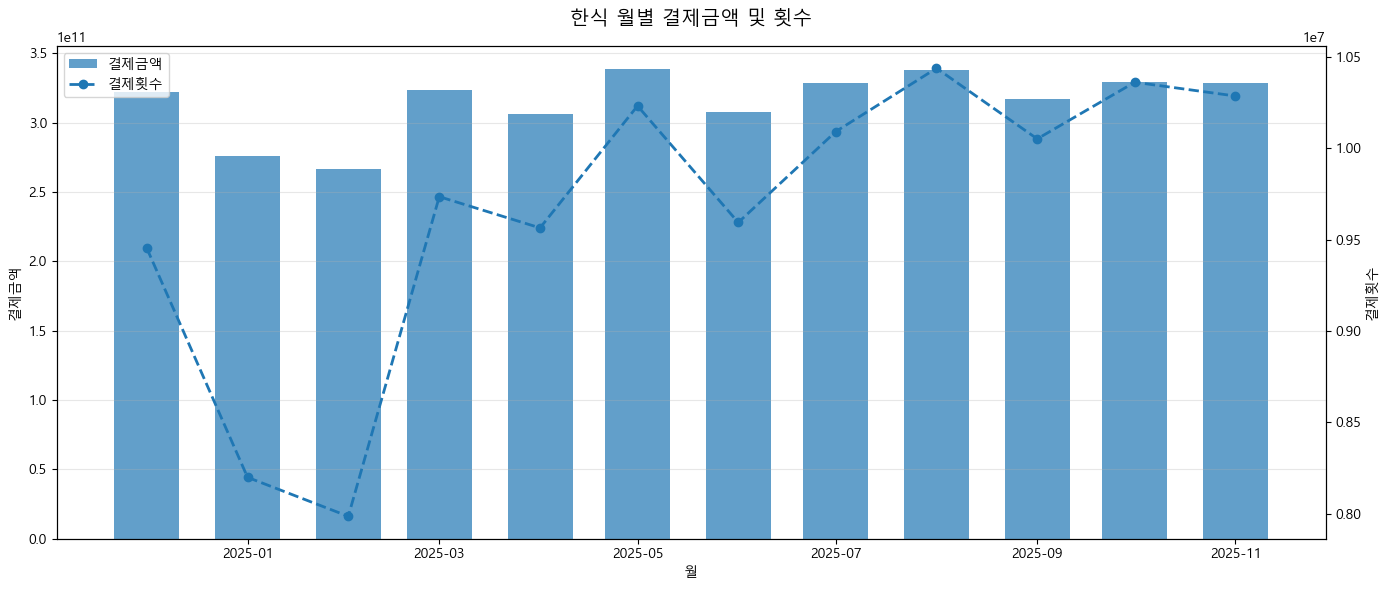

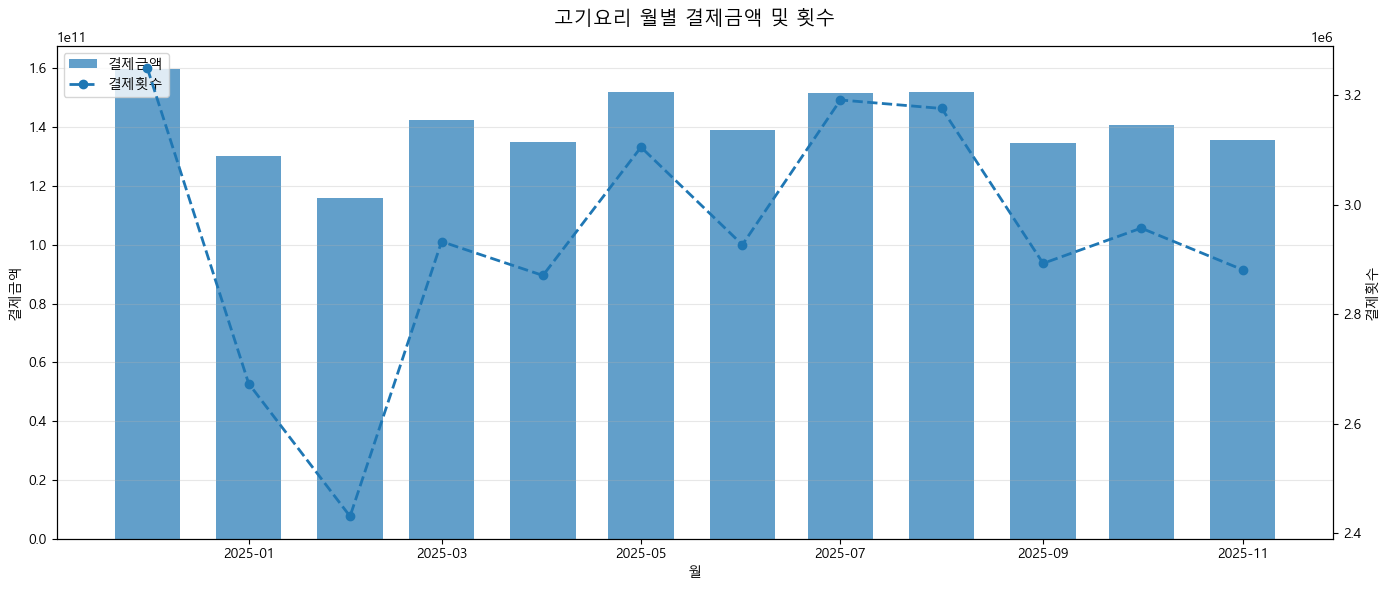

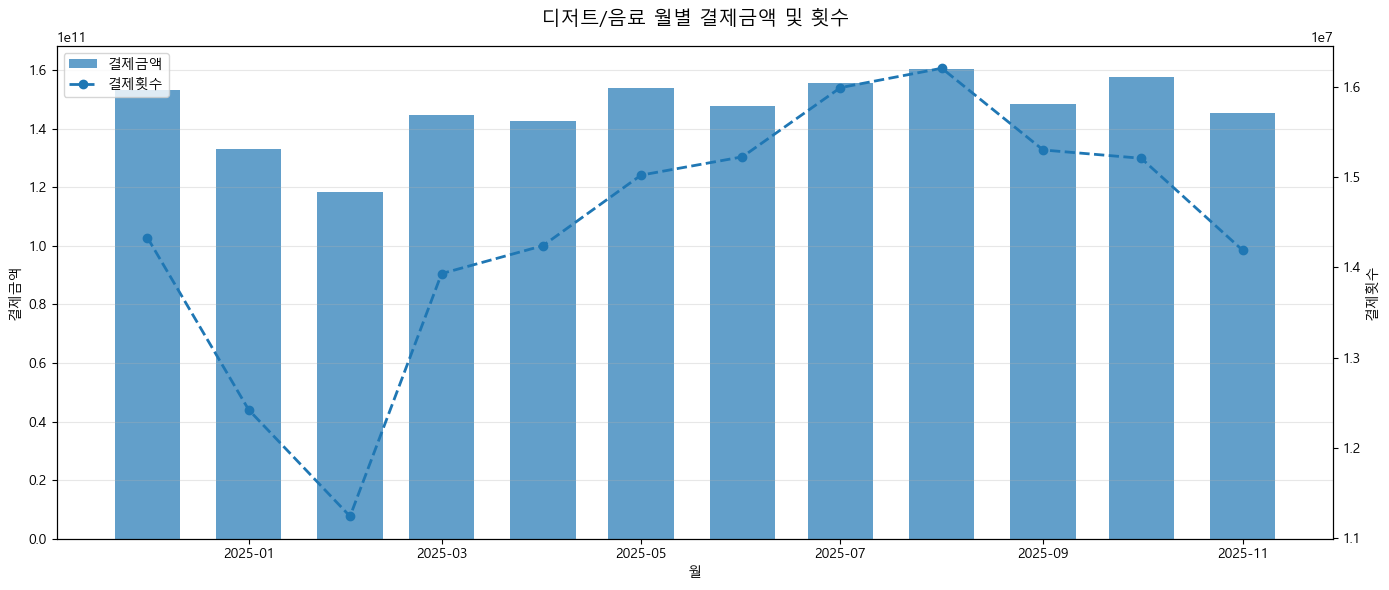

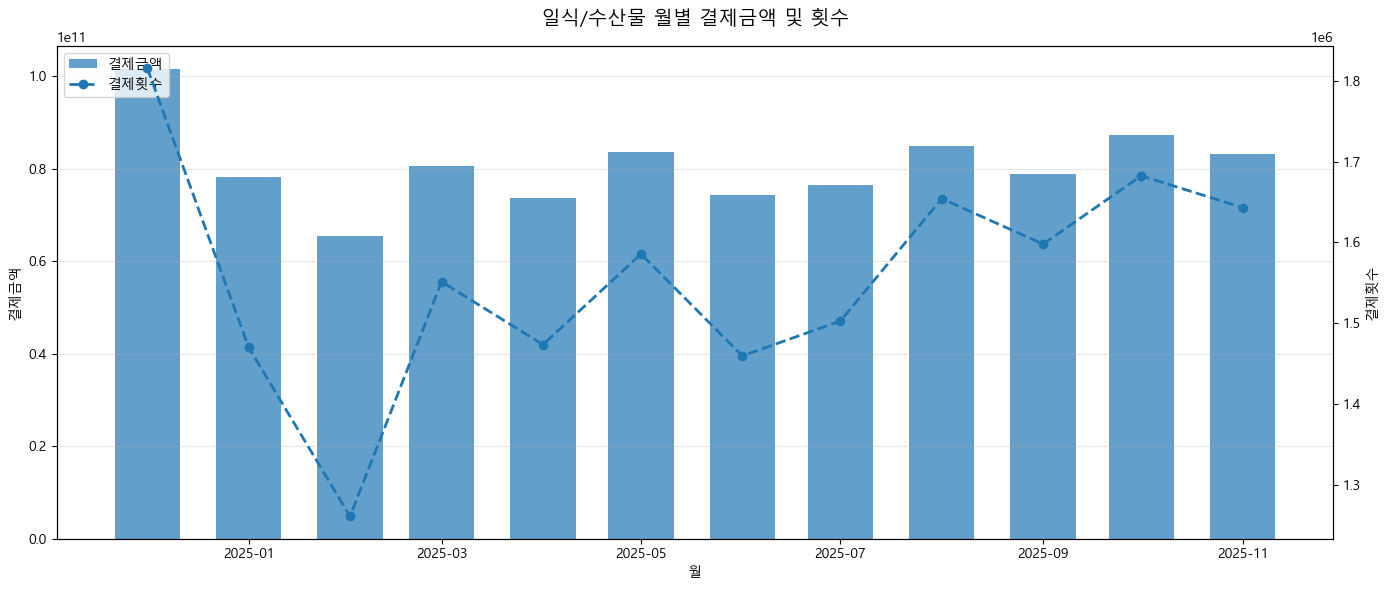

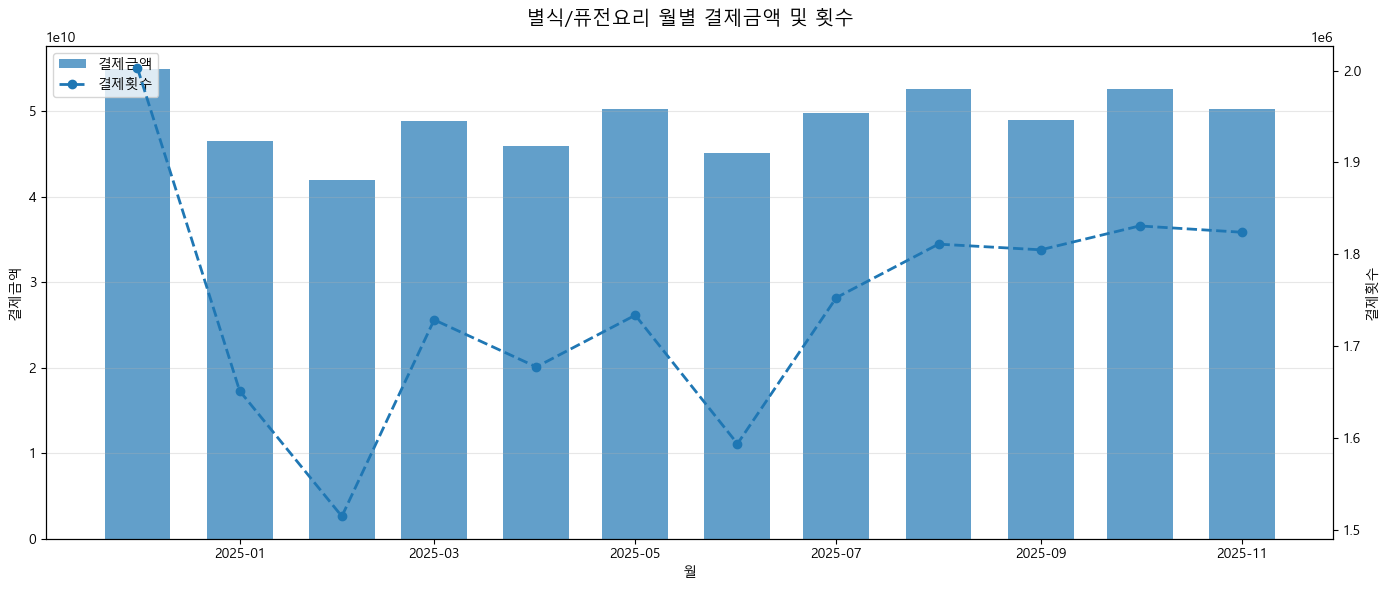

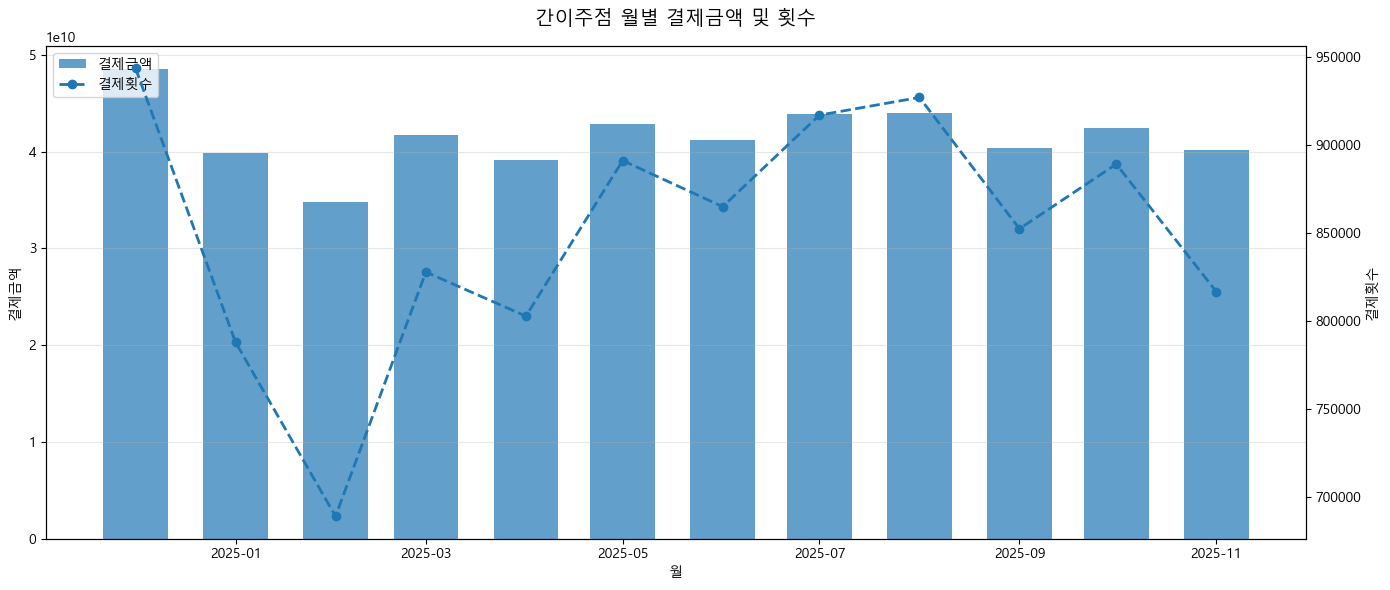

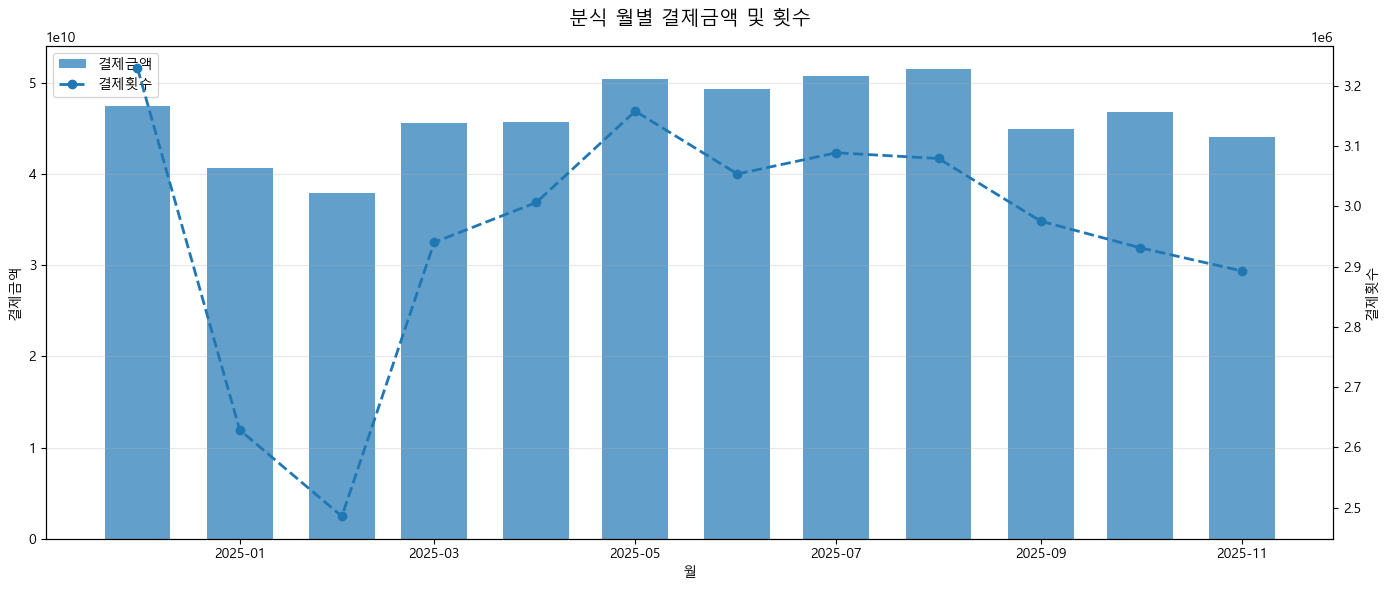

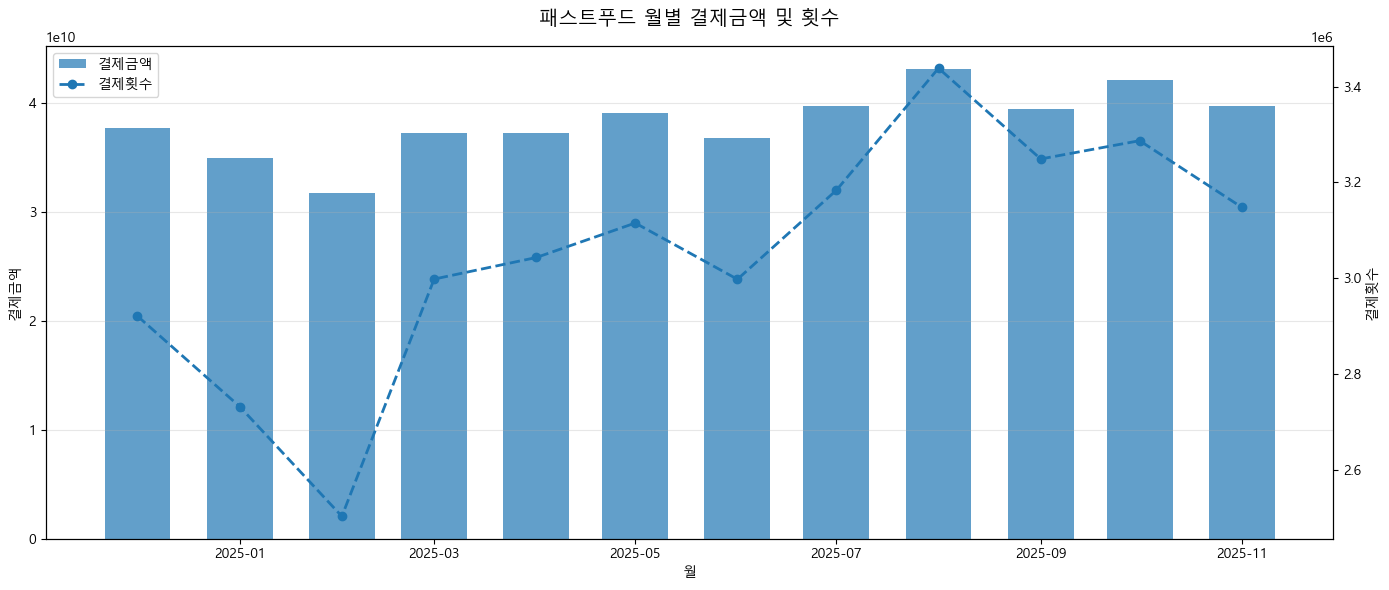

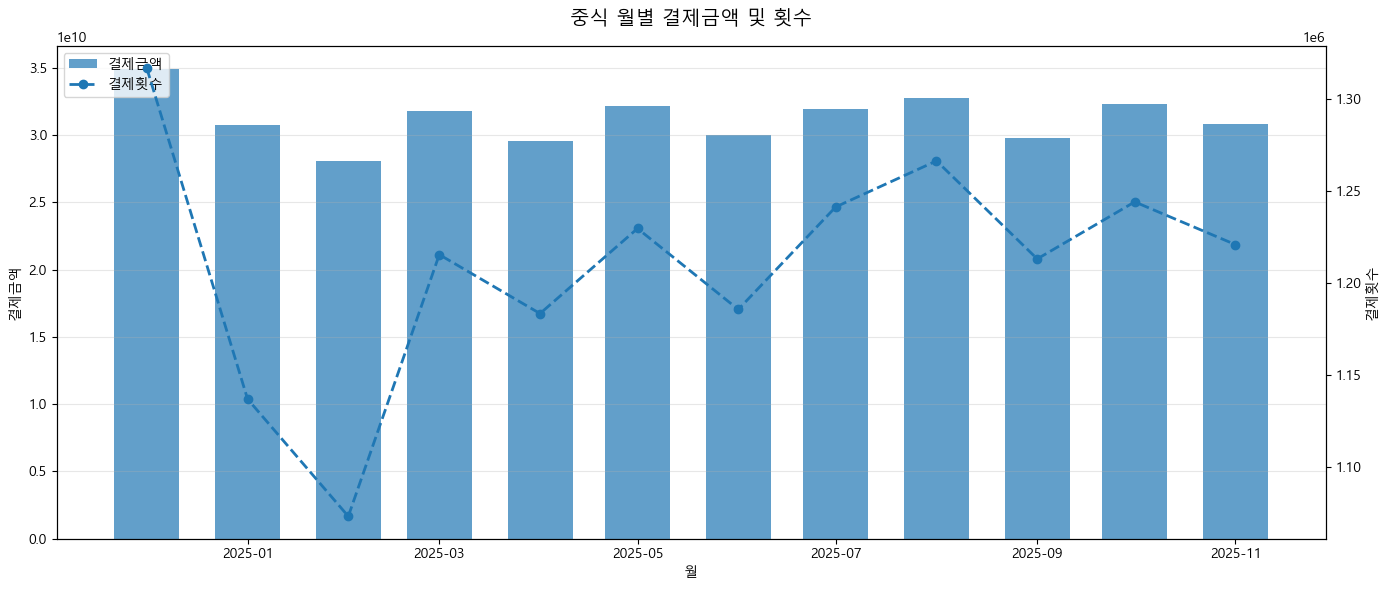

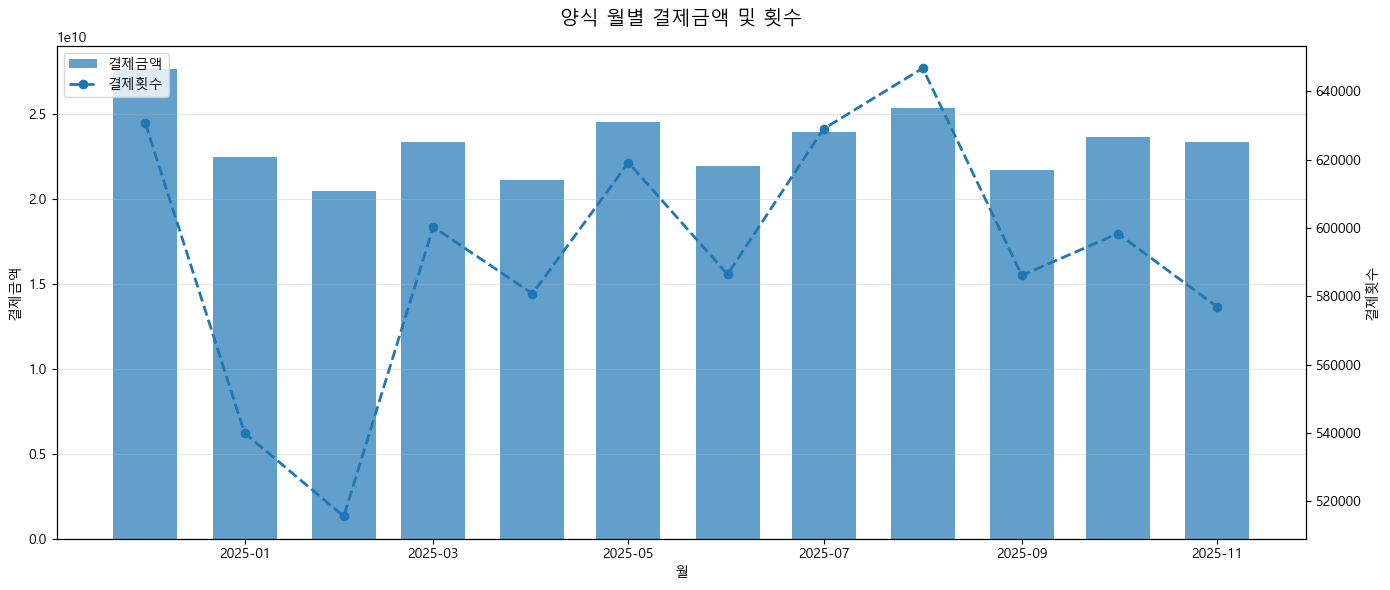

In [14]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ============================================================
# 한글 폰트 설정 (Windows)
# ============================================================
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# ============================================================
# Parquet 데이터 읽기
# ============================================================
df = pd.read_parquet(
    "../output/category_monthly_summary_202412_202511.parquet"
)

# ============================================================
# YYYYMM → datetime
# ============================================================
df['year_month'] = pd.to_datetime(
    df['year_month'].astype(str),
    format='%Y%m'
)
df = df.sort_values('year_month')

# ============================================================
# 업종별 시각화
# ============================================================
categories = df['card_tpbuz_nm_2'].unique()

for category in categories:
    sub = df[df['card_tpbuz_nm_2'] == category]

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # ------------------------------
    # 결제금액 → 막대차트 (좌측 y축)
    # ------------------------------
    bars = ax1.bar(
        sub['year_month'],
        sub['amt'],
        width=20,            # 막대 폭 (월 단위)
        alpha=0.7,
        label='결제금액'
    )
    ax1.set_ylabel('결제금액')
    ax1.set_xlabel('월')

    # ------------------------------
    # 결제횟수 → 선 그래프 (우측 y축)
    # ------------------------------
    ax2 = ax1.twinx()
    line = ax2.plot(
        sub['year_month'],
        sub['cnt'],
        marker='o',
        linewidth=2,
        linestyle='--',
        label='결제횟수'
    )
    ax2.set_ylabel('결제횟수')

    # ------------------------------
    # 제목
    # ------------------------------
    plt.title(f"{category} 월별 결제금액 및 횟수", fontsize=14, pad=15)

    # ------------------------------
    # 범례 통합
    # ------------------------------
    lines = [bars, line[0]]
    labels = ['결제금액', '결제횟수']
    ax1.legend(lines, labels, loc='upper left')

    # ------------------------------
    # 가독성
    # ------------------------------
    plt.xticks(rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    plt.tight_layout()

    plt.show()


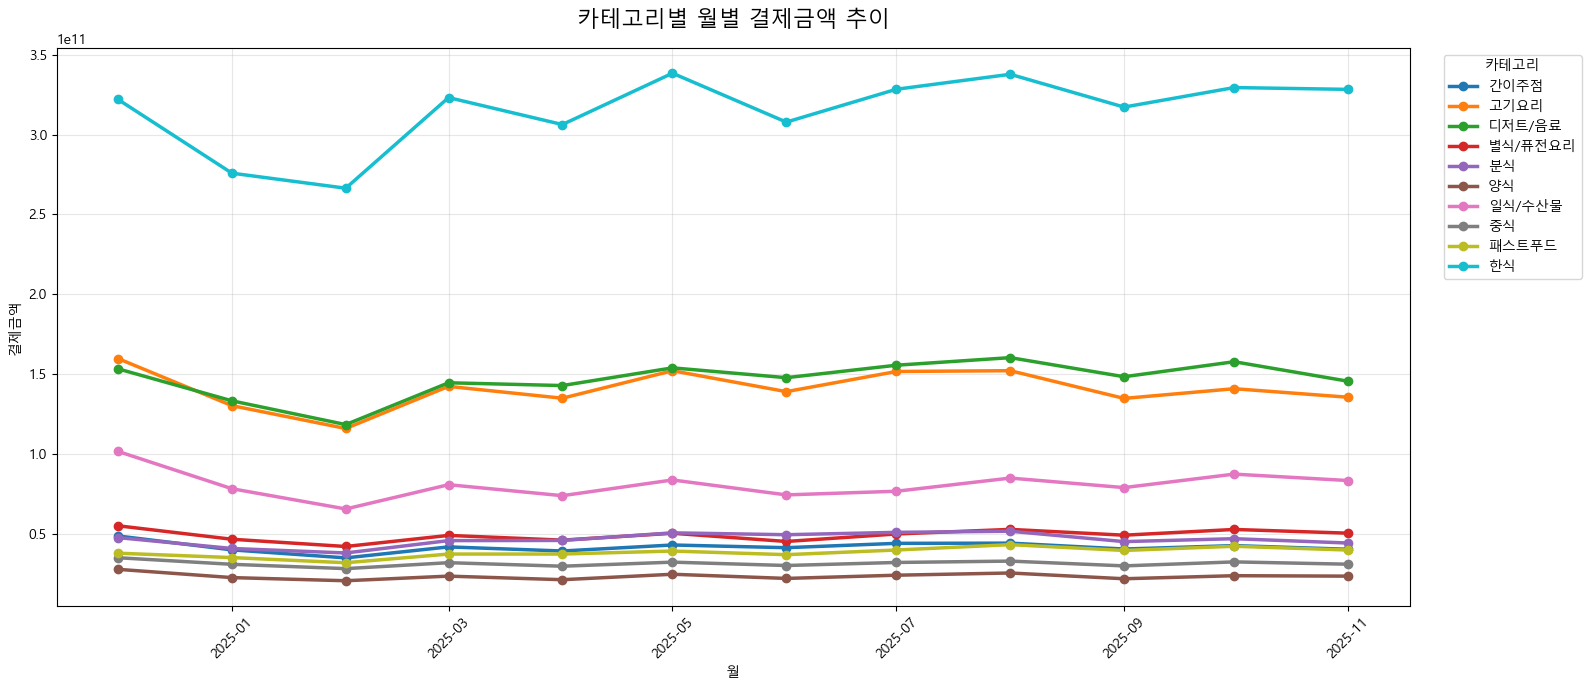

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 7))

categories = sorted(df["card_tpbuz_nm_2"].unique())

# 🔥 명확한 색상 팔레트
colors = plt.cm.tab10.colors  # 최대 10개까지 매우 구분 잘 됨

for i, category in enumerate(categories):
    sub = df[df["card_tpbuz_nm_2"] == category]

    plt.plot(
        sub["year_month"],
        sub["amt"],
        label=category,
        linewidth=2.5,
        marker="o",
        color=colors[i % len(colors)]
    )

plt.title("카테고리별 월별 결제금액 추이", fontsize=16, pad=15)
plt.xlabel("월")
plt.ylabel("결제금액")

plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# 🔥 범례를 그래프 밖으로
plt.legend(
    title="카테고리",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


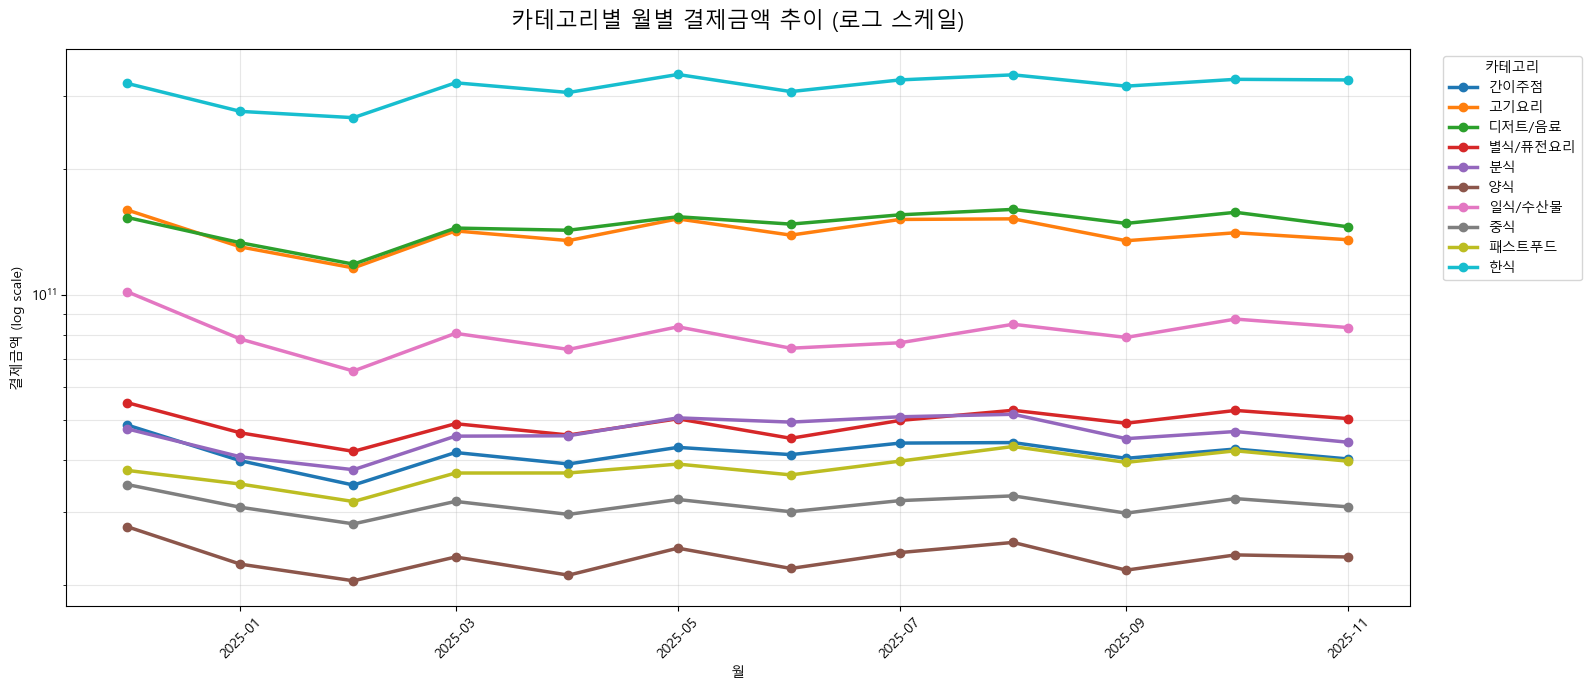

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 7))

categories = sorted(df["card_tpbuz_nm_2"].unique())
colors = plt.cm.tab10.colors

for i, category in enumerate(categories):
    sub = df[df["card_tpbuz_nm_2"] == category]

    plt.plot(
        sub["year_month"],
        sub["amt"],
        label=category,
        linewidth=2.5,
        marker="o",
        color=colors[i % len(colors)]
    )

# 🔥 로그 스케일 적용
plt.yscale("log")

plt.title("카테고리별 월별 결제금액 추이 (로그 스케일)", fontsize=16, pad=15)
plt.xlabel("월")
plt.ylabel("결제금액 (log scale)")

plt.xticks(rotation=45)
plt.grid(alpha=0.3, which="both")  # 로그 스케일에서는 both 권장

plt.legend(
    title="카테고리",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


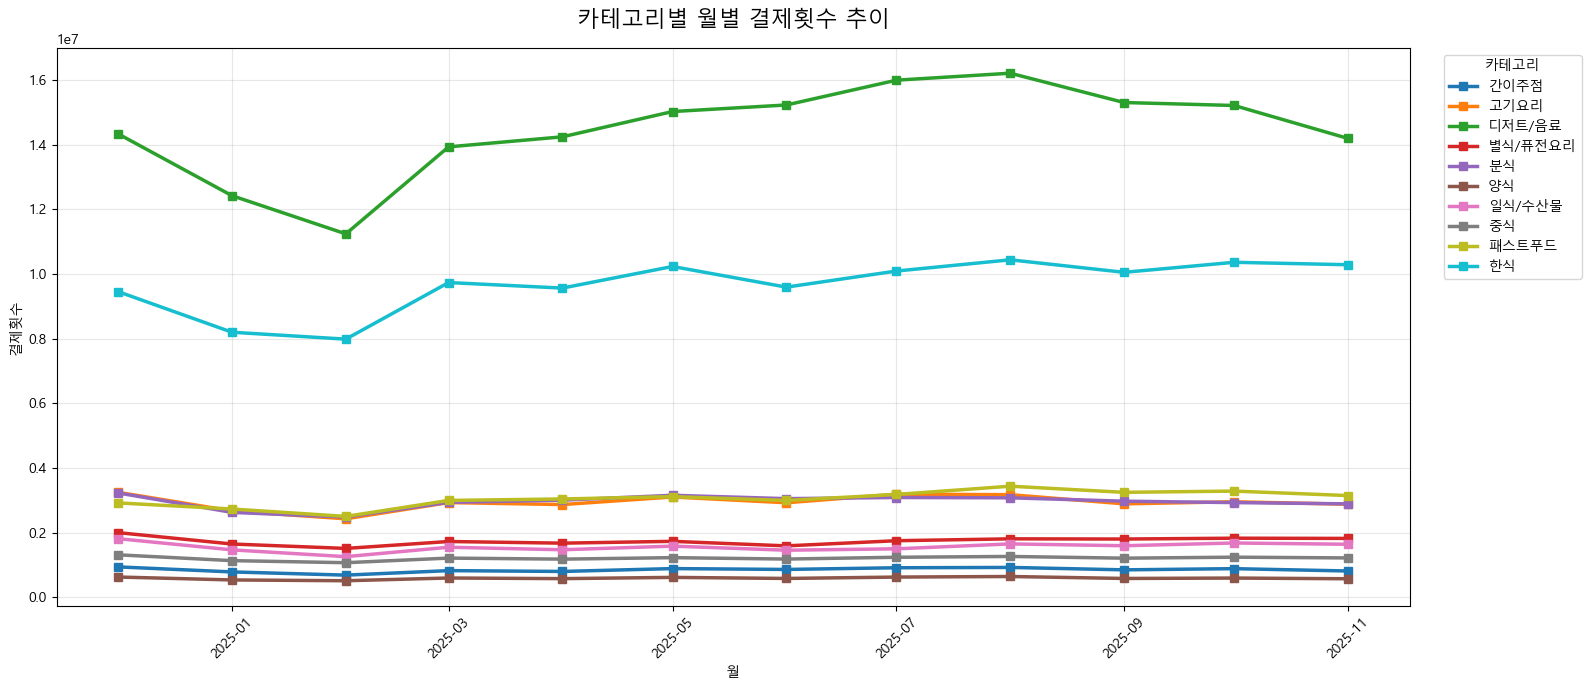

In [18]:
plt.figure(figsize=(16, 7))

for i, category in enumerate(categories):
    sub = df[df["card_tpbuz_nm_2"] == category]

    plt.plot(
        sub["year_month"],
        sub["cnt"],
        label=category,
        linewidth=2.5,
        marker="s",
        color=colors[i % len(colors)]
    )

plt.title("카테고리별 월별 결제횟수 추이", fontsize=16, pad=15)
plt.xlabel("월")
plt.ylabel("결제횟수")

plt.xticks(rotation=45)
plt.grid(alpha=0.3)

plt.legend(
    title="카테고리",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()


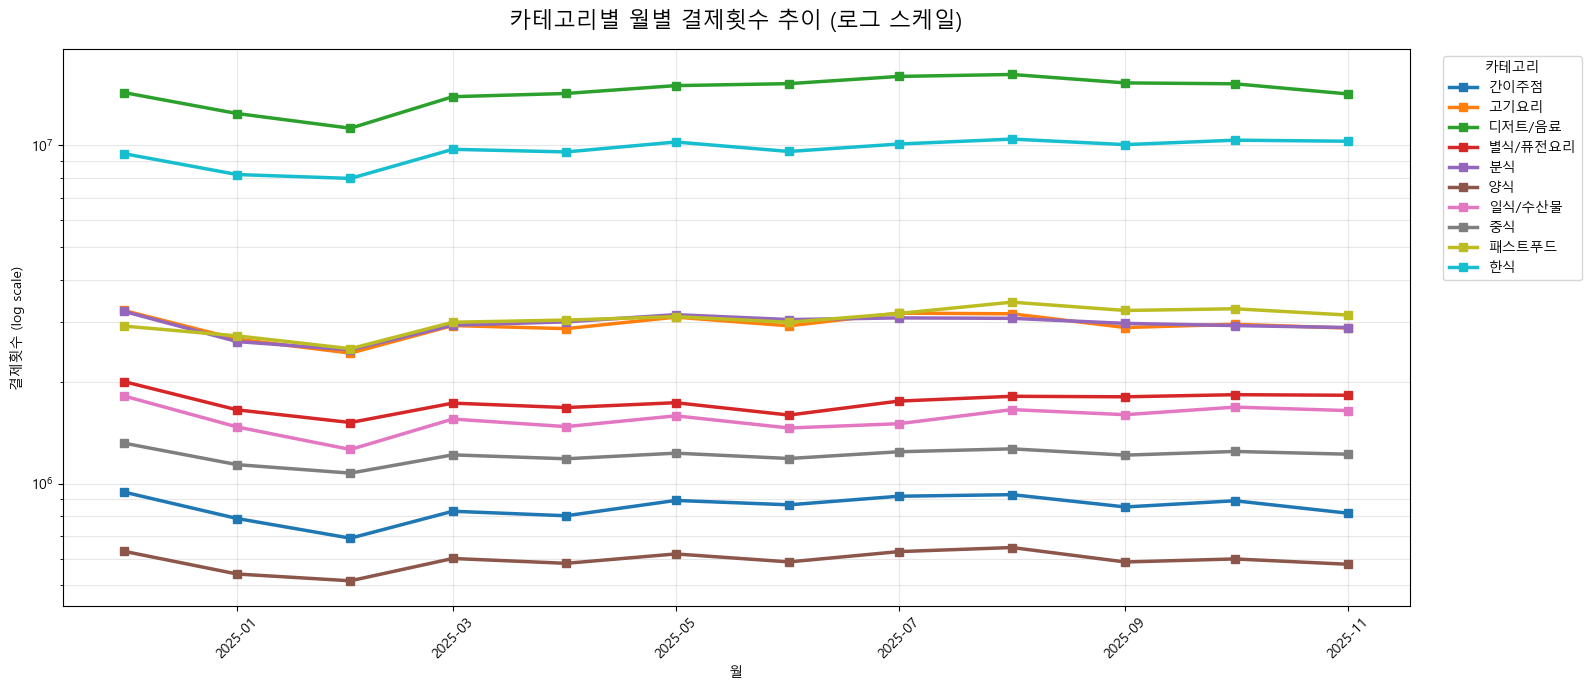

In [19]:
plt.figure(figsize=(16, 7))

for i, category in enumerate(categories):
    sub = df[df["card_tpbuz_nm_2"] == category]

    plt.plot(
        sub["year_month"],
        sub["cnt"],
        label=category,
        linewidth=2.5,
        marker="s",
        color=colors[i % len(colors)]
    )
    
# 🔥 로그 스케일 적용
plt.yscale("log")

plt.title("카테고리별 월별 결제횟수 추이 (로그 스케일)", fontsize=16, pad=15)
plt.xlabel("월")
plt.ylabel("결제횟수 (log scale)")

plt.xticks(rotation=45)
plt.grid(alpha=0.3, which="both")  # 로그 스케일에서는 both 권장

plt.legend(
    title="카테고리",
    bbox_to_anchor=(1.02, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

분석 대상 파일 수: 12


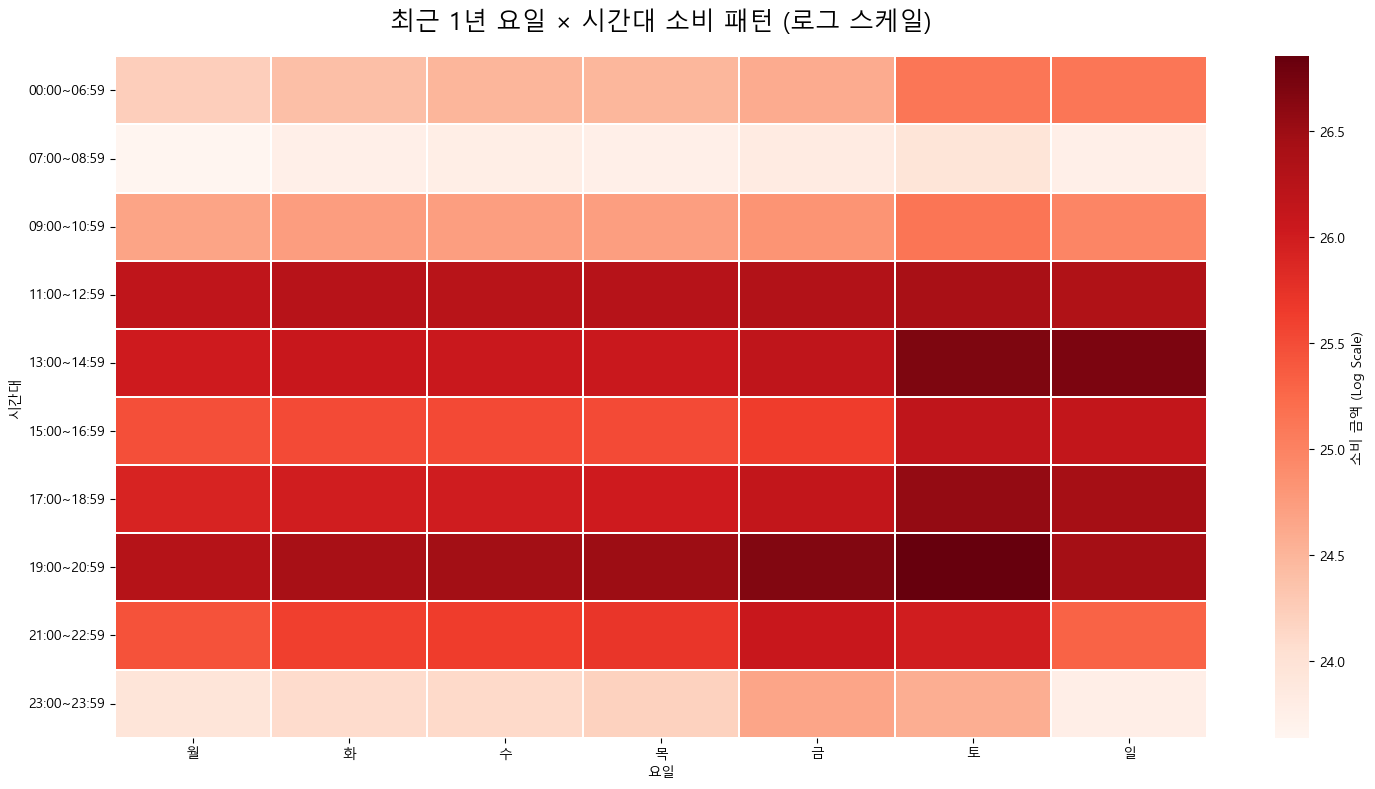

In [34]:
# ============================================================
# Parquet 기반 최근 1년(202412~202511) 요일 × 시간대 소비 히트맵
# ============================================================

import polars as pl
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# -------------------------------
# 1. 한글 폰트 설정
# -------------------------------
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# -------------------------------
# 2. 경로 및 매핑 정보
# -------------------------------
DATA_PATH = "../food"

DAY_MAP = {1: '월', 2: '화', 3: '수', 4: '목', 5: '금', 6: '토', 7: '일'}
HOUR_MAP = {
    1: '00:00~06:59', 2: '07:00~08:59', 3: '09:00~10:59', 4: '11:00~12:59',
    5: '13:00~14:59', 6: '15:00~16:59', 7: '17:00~18:59',
    8: '19:00~20:59', 9: '21:00~22:59', 10: '23:00~23:59'
}

day_order = ['월', '화', '수', '목', '금', '토', '일']
hour_order = [HOUR_MAP[i] for i in range(1, 11)]

# -------------------------------
# 3. Parquet 파일 필터링 (최근 1년)
# -------------------------------
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

target_files = [
    f for f in files
    if "202412" <= os.path.basename(f).replace(".parquet", "") <= "202511"
]

if not target_files:
    raise ValueError("202412~202511 기간의 Parquet 파일이 없습니다.")

print(f"분석 대상 파일 수: {len(target_files)}")

# -------------------------------
# 4. Lazy Scan + 요일/시간 집계
# -------------------------------
lf = (
    pl.scan_parquet(target_files)
      .select(["hour", "day", "amt"])
      .group_by(["hour", "day"])
      .agg(
          pl.col("amt").sum().alias("amt")
      )
)

df = lf.collect().to_pandas()

# -------------------------------
# 5. 요일 / 시간대 라벨 매핑
# -------------------------------
df["day_str"] = df["day"].map(DAY_MAP)
df["hour_str"] = df["hour"].map(HOUR_MAP)

# -------------------------------
# 6. 피벗 테이블 생성
# -------------------------------
pivot_df = (
    df.pivot(index="hour_str", columns="day_str", values="amt")
      .reindex(index=hour_order, columns=day_order)
)

# -------------------------------
# 7. 히트맵 시각화 (Log Scale)
# -------------------------------
plt.figure(figsize=(15, 8))

sns.heatmap(
    np.log1p(pivot_df),
    cmap="Reds",
    annot=False,
    linewidths=0.1,
    cbar_kws={"label": "소비 금액 (Log Scale)"}
)

plt.title("최근 1년 요일 × 시간대 소비 패턴 (로그 스케일)", fontsize=18, pad=20)
plt.xlabel("요일")
plt.ylabel("시간대")
plt.tight_layout()
plt.show()


분석 대상 Parquet 파일 수: 12


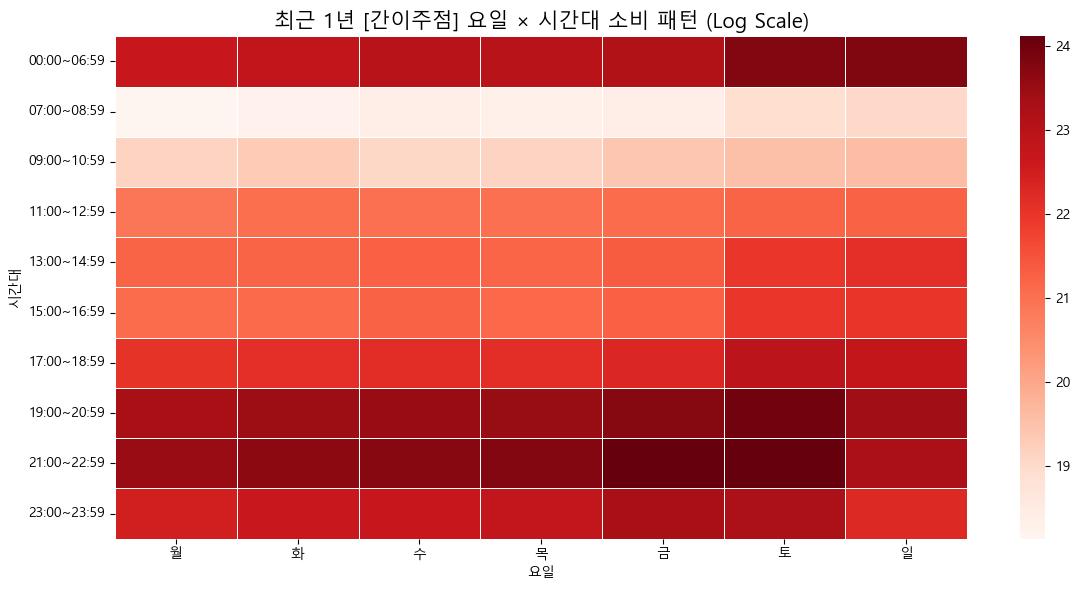

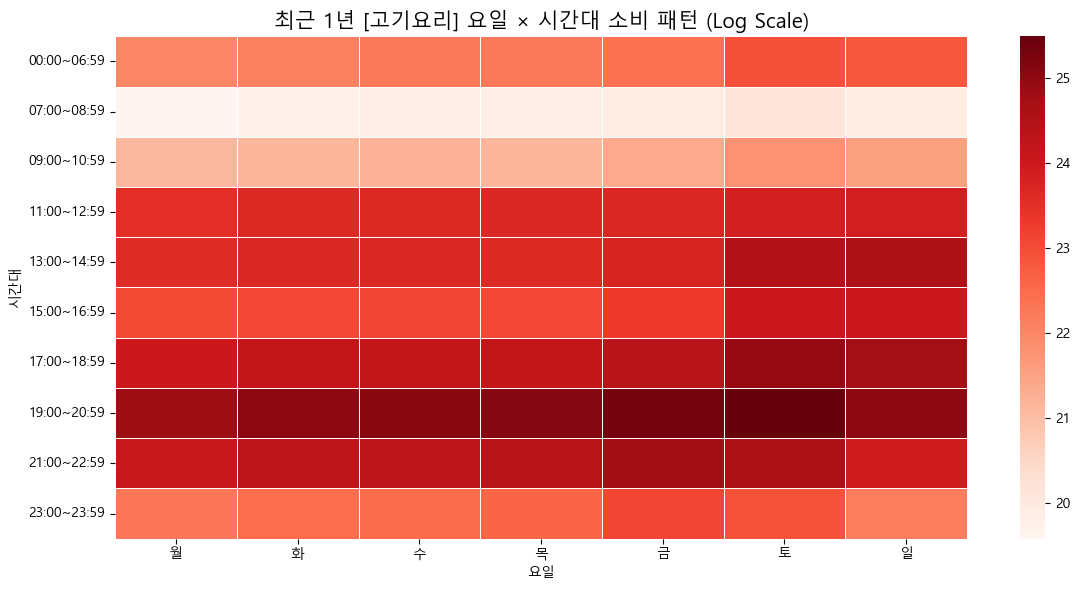

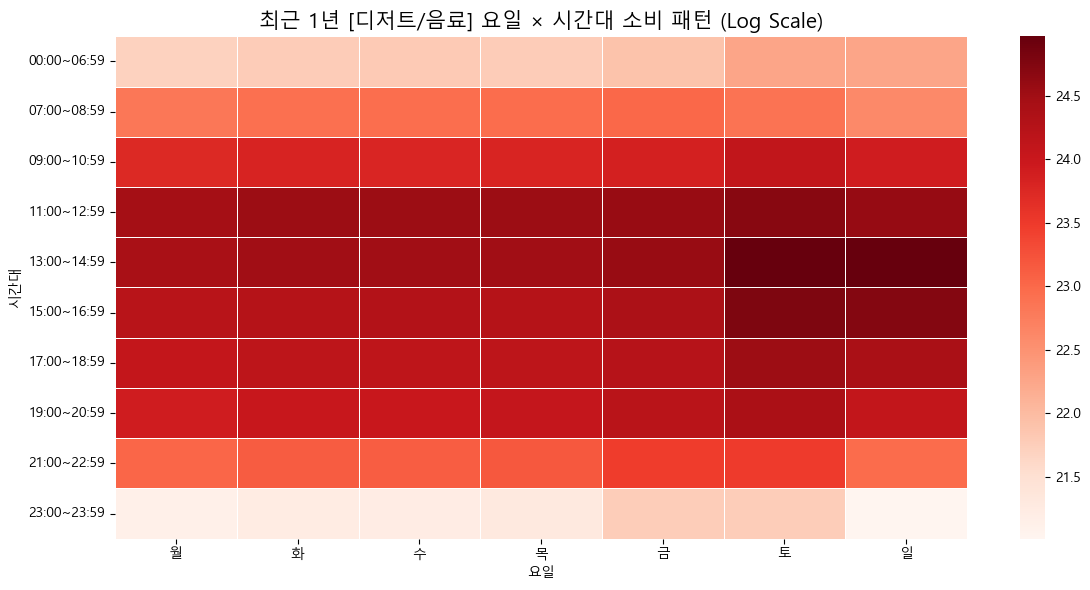

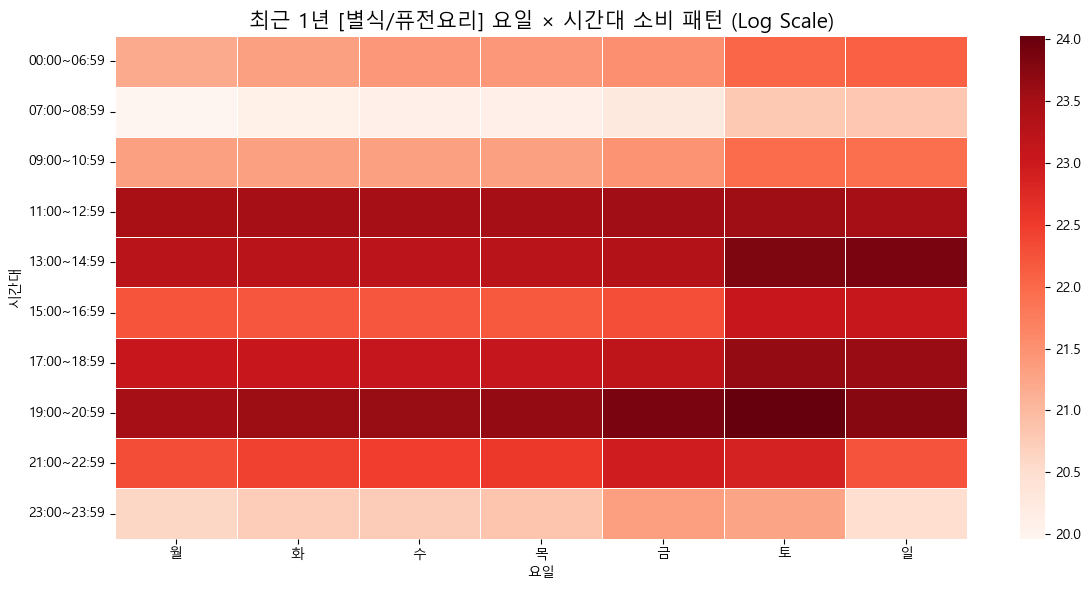

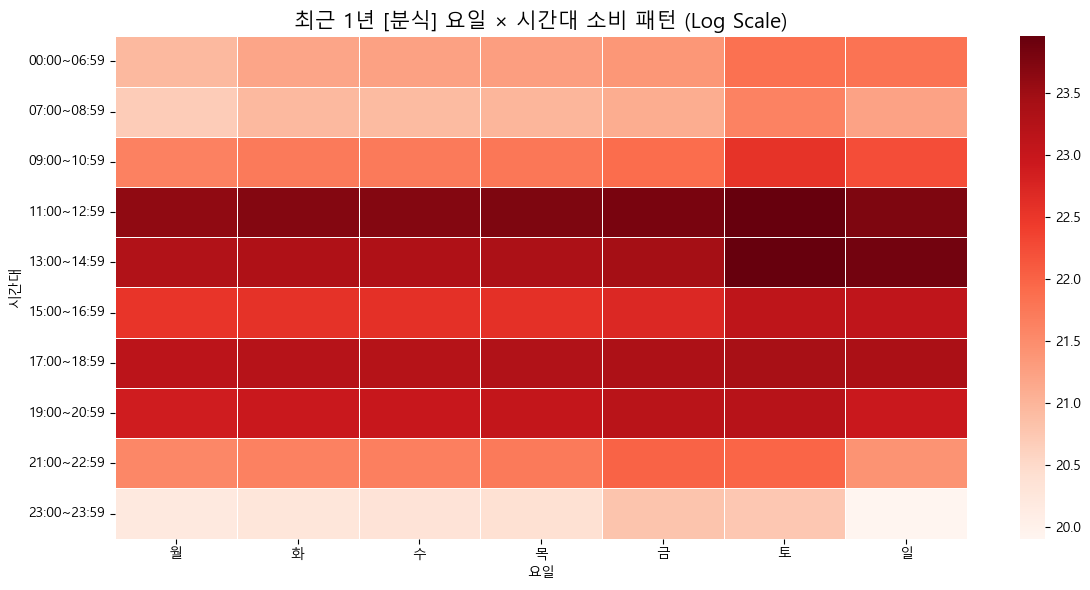

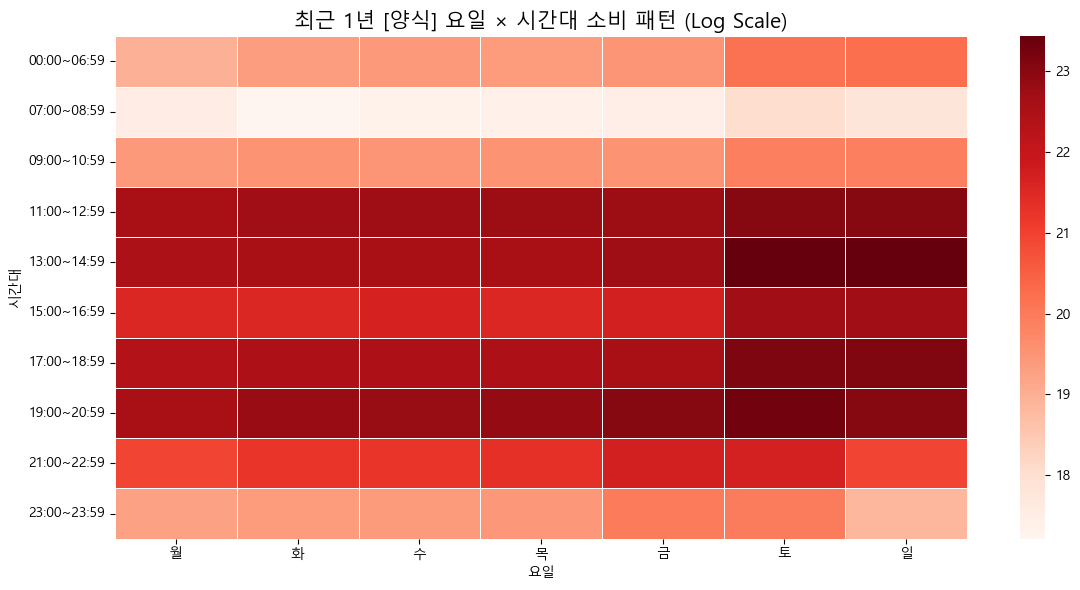

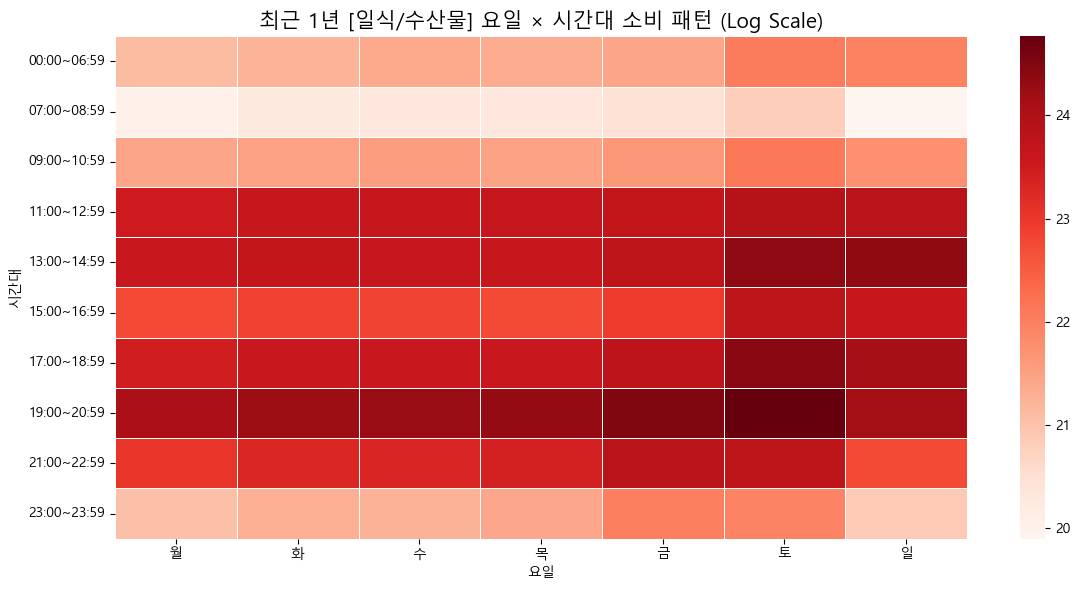

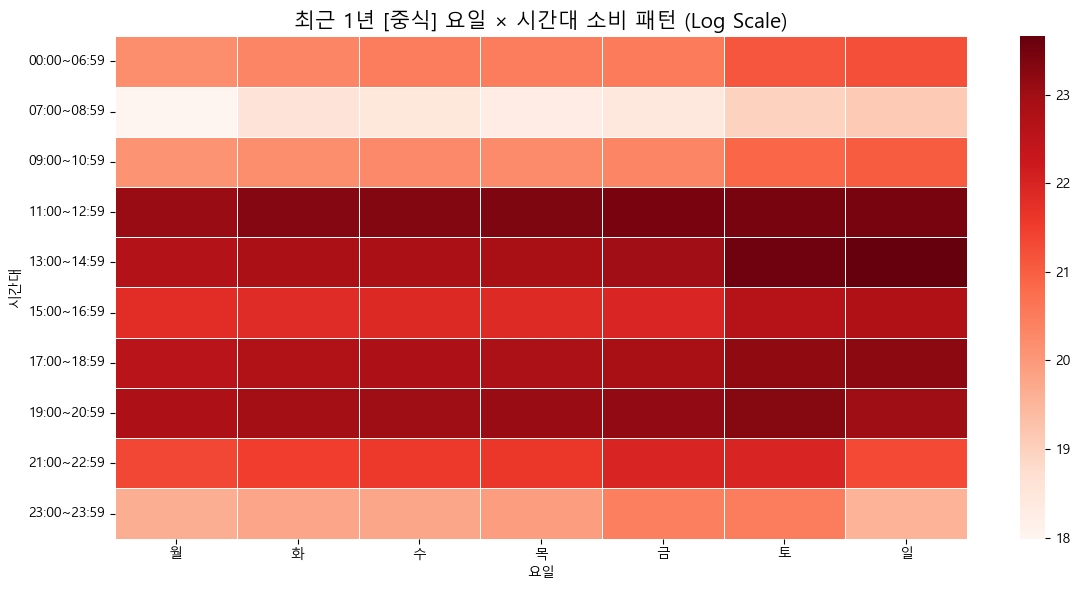

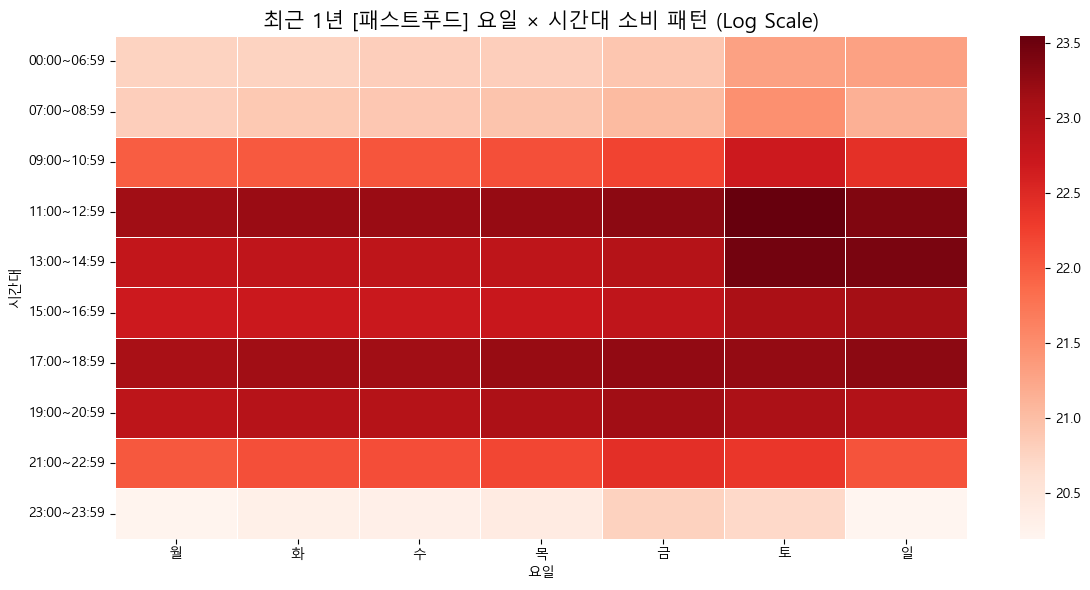

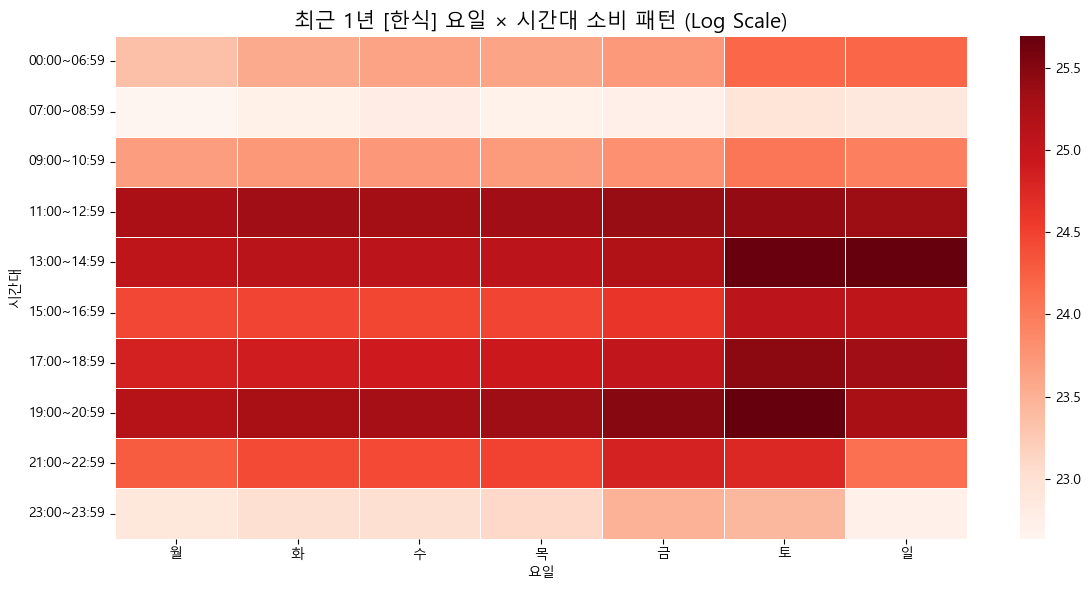

In [33]:
# ============================================================
# Parquet 기반 최근 1년(202412~202511)
# 업종(card_tpbuz_nm_2)별 요일 × 시간대 소비 히트맵
# ============================================================

import polars as pl
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# -------------------------------
# 1. 환경 설정
# -------------------------------
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

DATA_PATH = "../food"

DAY_MAP = {1: '월', 2: '화', 3: '수', 4: '목', 5: '금', 6: '토', 7: '일'}
HOUR_MAP = {
    1: '00:00~06:59', 2: '07:00~08:59', 3: '09:00~10:59', 4: '11:00~12:59',
    5: '13:00~14:59', 6: '15:00~16:59', 7: '17:00~18:59',
    8: '19:00~20:59', 9: '21:00~22:59', 10: '23:00~23:59'
}

DAY_ORDER = ['월', '화', '수', '목', '금', '토', '일']
HOUR_ORDER = [HOUR_MAP[i] for i in range(1, 11)]

# -------------------------------
# 2. Parquet 파일 필터링 (최근 1년)
# -------------------------------
files = sorted(glob.glob(os.path.join(DATA_PATH, "*.parquet")))

target_files = [
    f for f in files
    if "202412" <= os.path.basename(f).replace(".parquet", "") <= "202511"
]

if not target_files:
    raise ValueError("202412~202511 기간의 Parquet 파일이 없습니다.")

print(f"분석 대상 Parquet 파일 수: {len(target_files)}")

# -------------------------------
# 3. Lazy Scan + 업종/요일/시간 집계
# -------------------------------
lf = (
    pl.scan_parquet(target_files)
      .select(["card_tpbuz_nm_2", "hour", "day", "amt"])
      .with_columns(
          pl.col("card_tpbuz_nm_2")
          .cast(pl.Utf8)
          .str.replace(r"^\s+|\s+$", "")
      )
      .group_by(["card_tpbuz_nm_2", "hour", "day"])
      .agg(
          pl.col("amt").sum().alias("amt")
      )
)

df = lf.collect().to_pandas()

# -------------------------------
# 4. 요일 / 시간대 라벨 매핑
# -------------------------------
df["day_str"] = df["day"].map(DAY_MAP)
df["hour_str"] = df["hour"].map(HOUR_MAP)

# -------------------------------
# 5. 업종별 히트맵 함수
# -------------------------------
def draw_category_heatmap(df, category_name):
    sub_df = df[df["card_tpbuz_nm_2"] == category_name]

    pivot = (
        sub_df.pivot_table(
            index="hour_str",
            columns="day_str",
            values="amt",
            aggfunc="sum"
        )
        .reindex(index=HOUR_ORDER, columns=DAY_ORDER)
        .fillna(0)
    )

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        np.log1p(pivot),
        cmap="Reds",
        annot=False,
        linewidths=0.5
    )

    plt.title(f"최근 1년 [{category_name}] 요일 × 시간대 소비 패턴 (Log Scale)", fontsize=15)
    plt.xlabel("요일")
    plt.ylabel("시간대")
    plt.tight_layout()
    plt.show()

# -------------------------------
# 6. 모든 업종 순회 시각화
# -------------------------------
categories = sorted(df["card_tpbuz_nm_2"].unique())

for cat in categories:
    draw_category_heatmap(df, cat)


In [47]:
# ============================================================
# Parquet 기반 최근 1년(202412~202511)
# 월 × 연령대 × 업종(card_tpbuz_nm_2) 소비금액 집계
# ============================================================

import polars as pl
import pandas as pd
import glob
import os

DATA_DIR = "../food"
OUTPUT_DIR = "../output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------
# 1. Parquet 파일 필터링
# -------------------------------
all_files = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))

target_files = [
    f for f in all_files
    if "202412" <= os.path.basename(f).replace(".parquet", "") <= "202511"
]

if not target_files:
    raise ValueError("202412~202511 기간의 Parquet 파일이 없습니다.")

print(f"분석 대상 Parquet 파일 수: {len(target_files)}")

# -------------------------------
# 2. Lazy Scan + 전처리 + 집계 (Polars)
# -------------------------------
lf = (
    pl.scan_parquet(target_files)
      .select(["ta_ymd", "age", "card_tpbuz_nm_2", "amt"])
      .with_columns([
          # YYYYMM
          pl.col("ta_ymd").cast(pl.Utf8).str.slice(0, 6).alias("month"),
      
          # 연령대 버킷 (⚠️ pl.lit 필수)
          pl.when(pl.col("age") == 2).then(pl.lit("20대"))
            .when(pl.col("age") == 3).then(pl.lit("30대"))
            .when(pl.col("age") == 4).then(pl.lit("40대"))
            .when(pl.col("age") == 5).then(pl.lit("50대"))
            .when(pl.col("age") == 6).then(pl.lit("60대+"))
            .otherwise(None)
            .alias("age_group"),
          
          # 업종 문자열 캐스팅
          pl.col("card_tpbuz_nm_2").cast(pl.Utf8)
      ])
      .filter(pl.col("age_group").is_not_null())
      .group_by(["month", "age_group", "card_tpbuz_nm_2"])
      .agg(
          pl.col("amt").sum().alias("total_amt")
      )
)

# -------------------------------
# 3. 결과 수집 → pandas 변환
# -------------------------------
df_final = lf.collect().to_pandas()

print(df_final.head())

# -------------------------------
# 4. CSV 저장
# -------------------------------
df_final.to_csv(
    f"{OUTPUT_DIR}/age_category_summary_202412_202511.csv",
    index=False,
    encoding="utf-8-sig"
)

# -------------------------------
# 5. 연령대 × 업종 Pivot
# -------------------------------
pivot = (
    df_final
    .groupby(["age_group", "card_tpbuz_nm_2"])["total_amt"]
    .sum()
    .unstack(fill_value=0)
)

pivot


분석 대상 Parquet 파일 수: 12
    month age_group card_tpbuz_nm_2    total_amt
0  202503       40대              한식  81600740791
1  202503       20대          일식/수산물   6180987552
2  202506      60대+              분식  10219840596
3  202508       20대            간이주점   8480781079
4  202504      60대+              한식  67598287554


card_tpbuz_nm_2          간이주점          고기요리        디저트/음료       별식/퓨전요리  \
age_group                                                                 
20대               99336172071  176981767670  212099552422   58218074535   
30대              126359015245  325924638149  386326807669  111847186204   
40대              130627957197  436401052849  478595553849  151328737448   
50대               99797699517  431109792465  405427905285  149930506871   
60대+              42737614858  318129489209  278498483538  116363431055   

card_tpbuz_nm_2            분식           양식        일식/수산물            중식  \
age_group                                                                
20대               50270877096  35381753592   77784355595   38838338075   
30대               98914663192  71714057477  163797314529   77289252396   
40대              151209186677  84986942884  225817398365  107825740976   
50대              147011917763  56571145039  262006598344   91919273481   
60대+             107926898153  30706193730  238664549311   58857689532   

card_tpbuz_nm_2         패스트푸드            한식  
age_group                                    
20대               79127191844  342056575074  
30대              109249520170  692888241646  
40대              129151007156  941758150904  
50대               96440201256  976328691116  
60대+              44782652200  828788704333

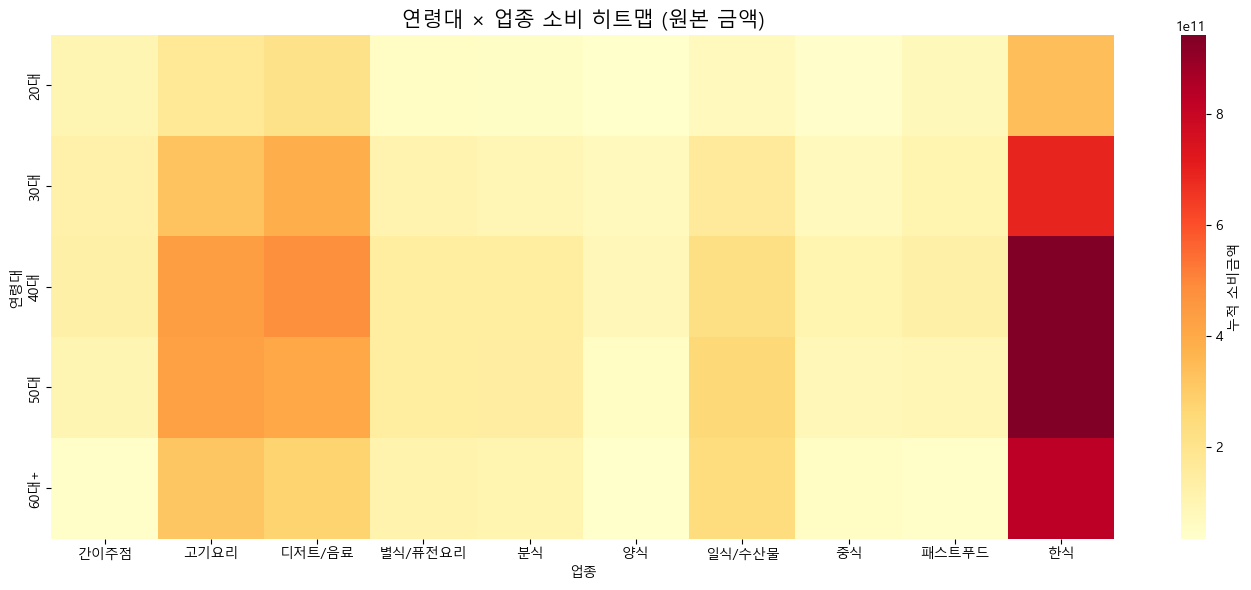

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# -------------------------------
# 1. 누적 소비금액 Pivot (원본)
# -------------------------------
pivot_amt = (
    df_final
    .groupby(["age_group", "card_tpbuz_nm_2"])["total_amt"]
    .sum()
    .unstack(fill_value=0)
)

# 연령대 순서 고정 (선택이지만 추천)
age_order = ["20대", "30대", "40대", "50대", "60대+"]
pivot_amt = pivot_amt.loc[age_order]

# -------------------------------
# 2. 히트맵 시각화
# -------------------------------
plt.figure(figsize=(14, 6))

sns.heatmap(
    pivot_amt,
    cmap="YlOrRd",
    robust=True,              # 극단값 영향 완화
    cbar_kws={"label": "누적 소비금액"}
)

plt.title("연령대 × 업종 소비 히트맵 (원본 금액)", fontsize=15)
plt.xlabel("업종")
plt.ylabel("연령대")
plt.tight_layout()
plt.show()


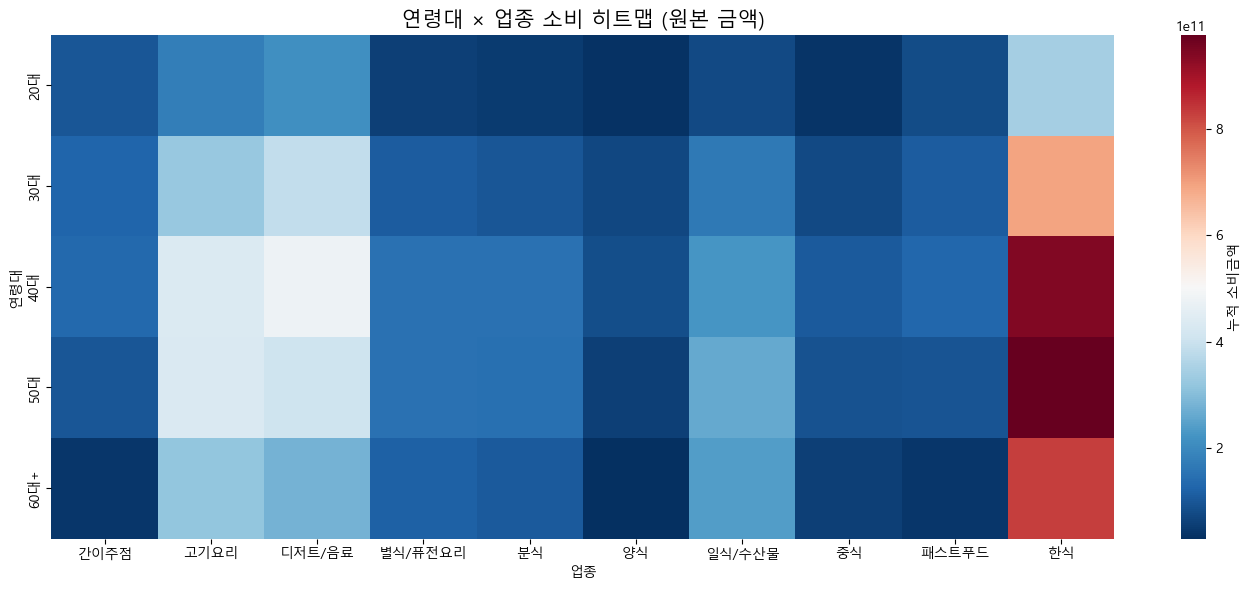

In [98]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot_amt,
    cmap="RdBu_r",
    cbar_kws={"label": "누적 소비금액"}
)

plt.title("연령대 × 업종 소비 히트맵 (원본 금액)", fontsize=15)
plt.xlabel("업종")
plt.ylabel("연령대")
plt.tight_layout()
plt.show()


In [99]:
pivot_z = pivot_amt.sub(pivot_amt.mean(axis=1), axis=0) \
                   .div(pivot_amt.std(axis=1), axis=0)                 
pivot_z

card_tpbuz_nm_2      간이주점      고기요리    디저트/음료   별식/퓨전요리        분식        양식  \
age_group                                                                     
20대             -0.179491  0.609082  0.965741 -0.597089 -0.677801 -0.829016   
30대             -0.453337  0.551087  0.855094 -0.526376 -0.591466 -0.728368   
40대             -0.569628  0.567726  0.724673 -0.492629 -0.493074 -0.739394   
50대             -0.612243  0.568063  0.476571 -0.433644 -0.444041 -0.766238   
60대+            -0.675382  0.460062  0.296663 -0.371822 -0.406606 -0.724988   

card_tpbuz_nm_2    일식/수산물        중식     패스트푸드        한식  
age_group                                                
20대             -0.398373 -0.793911 -0.384735  2.285592  
30대             -0.264908 -0.700308 -0.539450  2.398033  
40대             -0.215561 -0.654443 -0.575122  2.447453  
50대             -0.034370 -0.640310 -0.624204  2.510417  
60대+             0.132427 -0.608919 -0.666950  2.565515

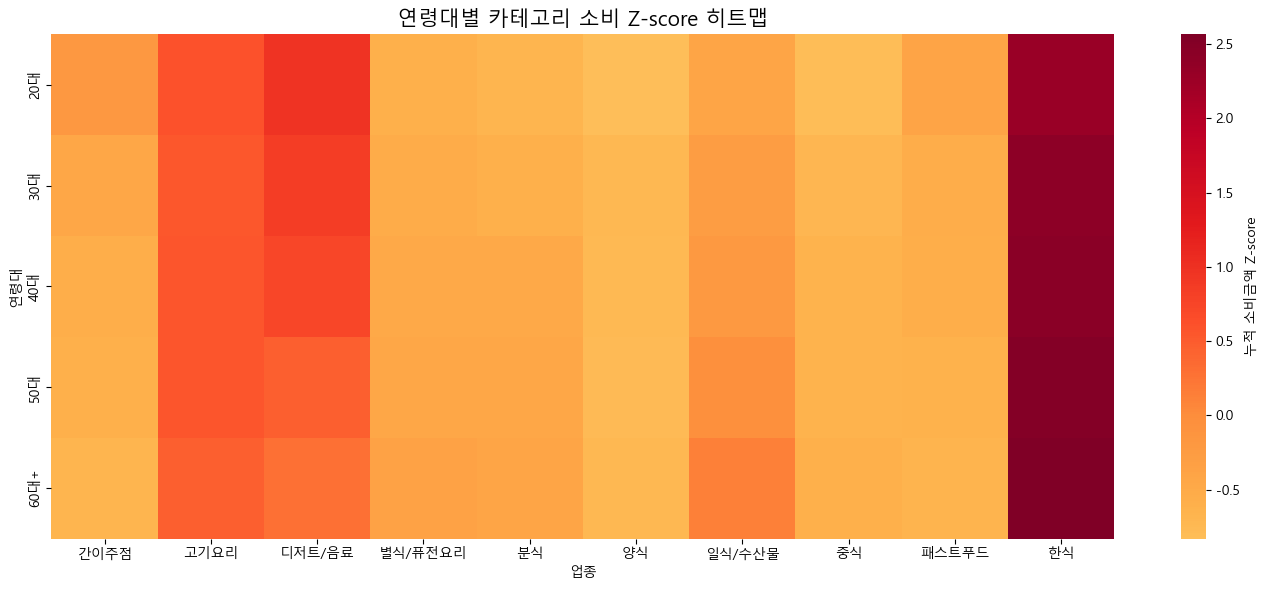

In [100]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot_z,
    cmap="YlOrRd",
    center=0,
    cbar_kws={"label": "누적 소비금액 Z-score"}
)

plt.title("연령대별 카테고리 소비 Z-score 히트맵", fontsize=15)
plt.xlabel("업종")
plt.ylabel("연령대")
plt.tight_layout()
plt.show()


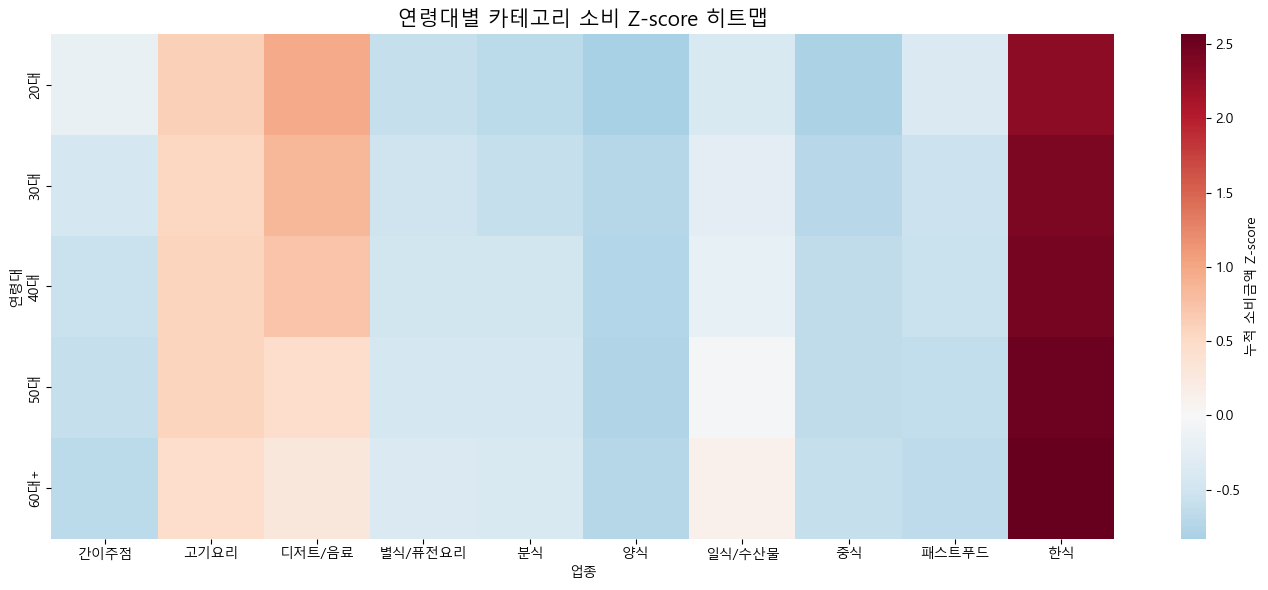

In [101]:
plt.figure(figsize=(14, 6))
sns.heatmap(
    pivot_z,
    cmap="RdBu_r",
    center=0,
    cbar_kws={"label": "누적 소비금액 Z-score"}
)

plt.title("연령대별 카테고리 소비 Z-score 히트맵", fontsize=15)
plt.xlabel("업종")
plt.ylabel("연령대")
plt.tight_layout()
plt.show()


In [51]:
TOP_N = 3

top_trend = (
    pivot_z_clipped
    .apply(lambda row: row.nlargest(TOP_N).index.tolist(), axis=1)
)

top_trend

age_group
20대     [한식, 디저트/음료, 고기요리]
30대     [한식, 디저트/음료, 고기요리]
40대     [한식, 디저트/음료, 고기요리]
50대     [한식, 고기요리, 디저트/음료]
60대+    [한식, 고기요리, 디저트/음료]
dtype: object

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ============================================================
# 한글 폰트 설정 (Windows)
# ============================================================
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

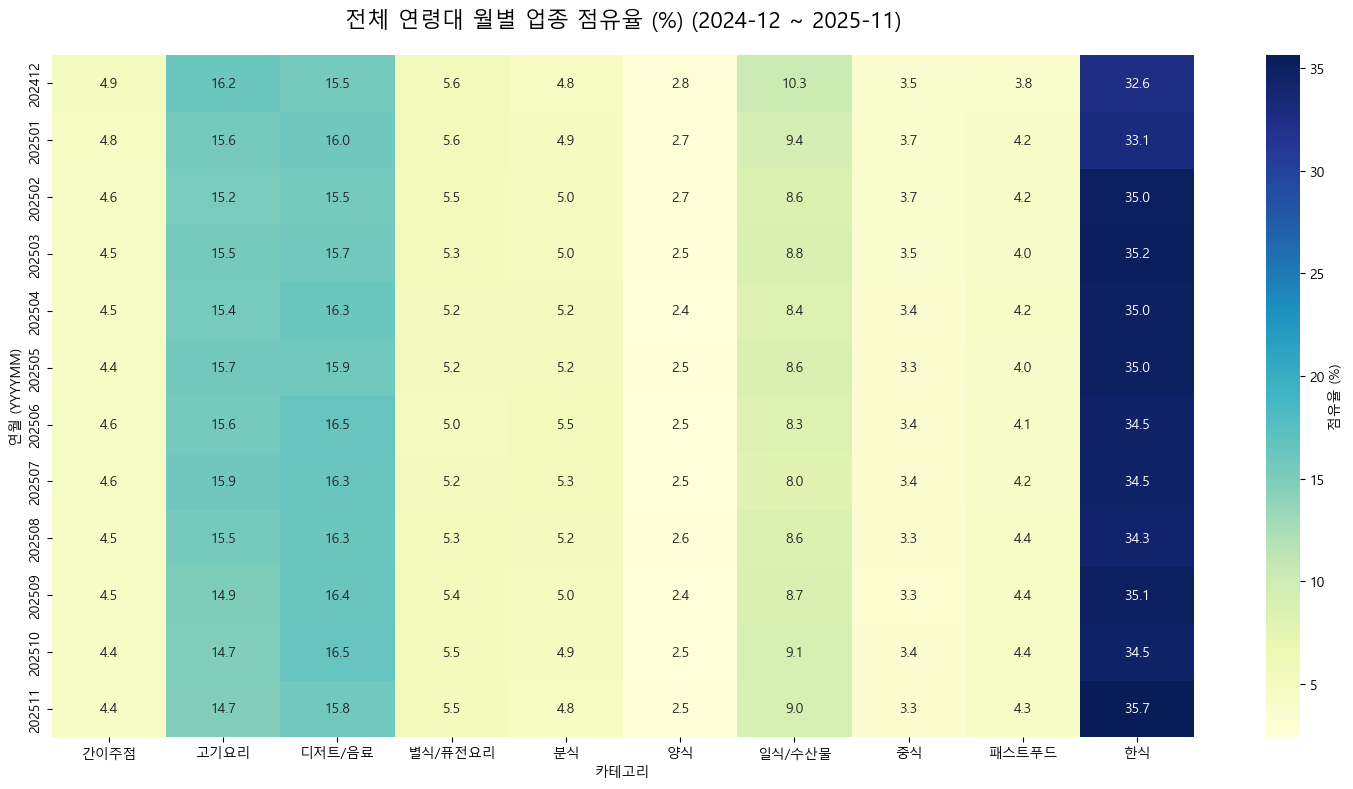

In [25]:
# =========================
# 전체 연령대 합산 히트맵 (연·월 기준)
# =========================

# 🔥 연-월 컬럼 사용
df_all_age = df_age.copy()
df_all_age['year_month'] = df_all_age['month'].astype(str)

# 월별/업종별 평균 매출 피벗
pivot_all = df_all_age.pivot_table(
    index='year_month',               # 🔥 YYYYMM
    columns='card_tpbuz_nm_2',
    values='total_amt',
    aggfunc='mean'
).sort_index()

# 점유율(%) 계산
share_all = pivot_all.div(
    pivot_all.sum(axis=1), axis=0
) * 100

plt.figure(figsize=(15, 8))
sns.heatmap(
    share_all,
    annot=True,
    fmt='.1f',
    cmap='YlGnBu',
    cbar_kws={'label': '점유율 (%)'}
)

plt.title('전체 연령대 월별 업종 점유율 (%) (2024-12 ~ 2025-11)', fontsize=16, pad=20)
plt.ylabel('연월 (YYYYMM)')
plt.xlabel('카테고리')
plt.tight_layout()
plt.show()


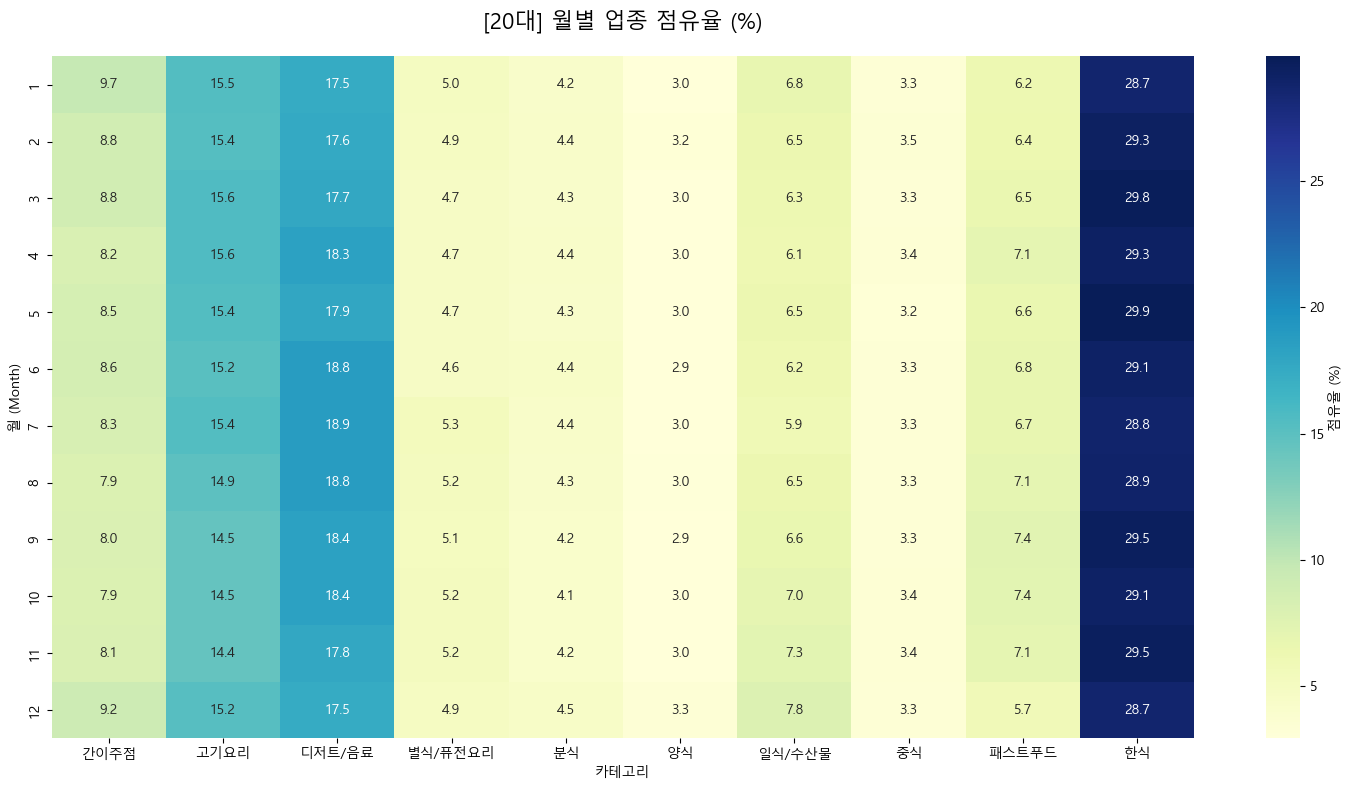

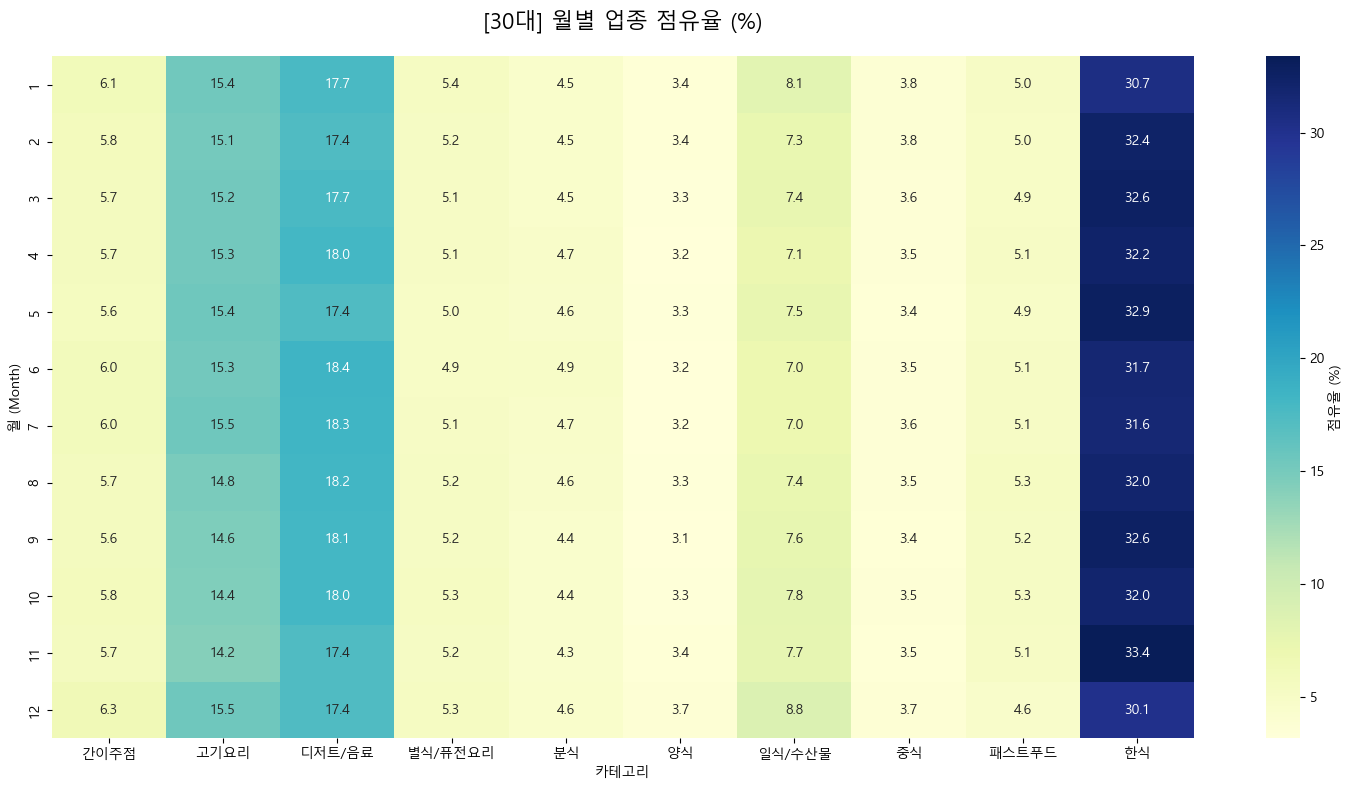

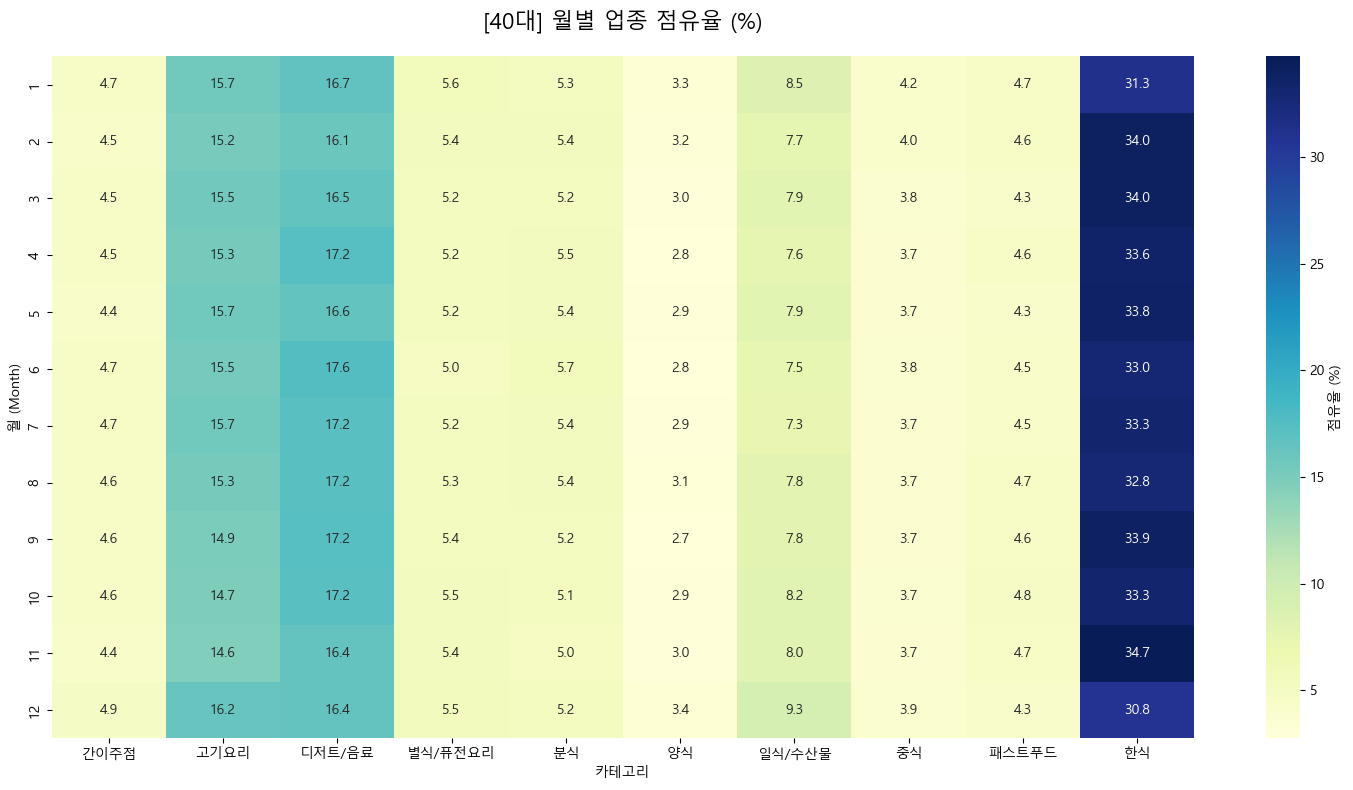

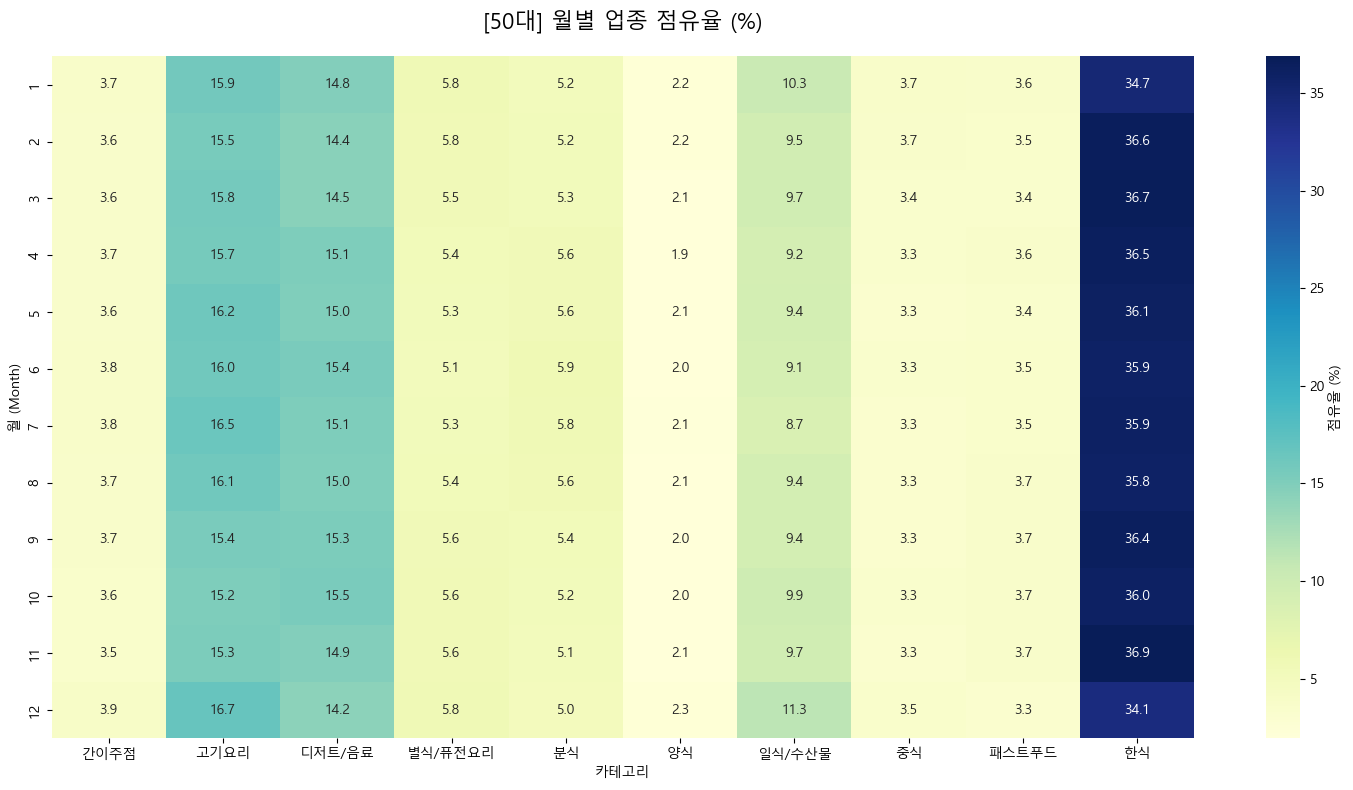

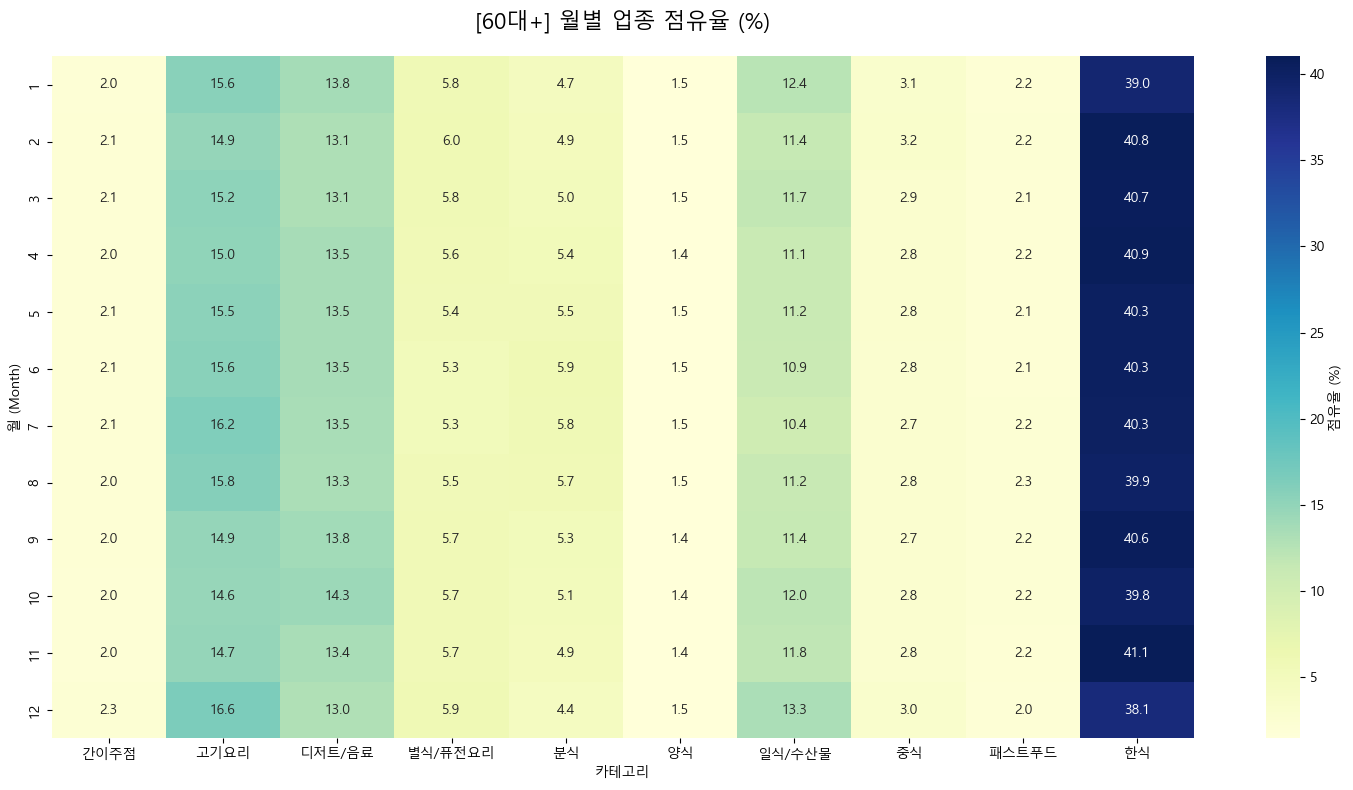

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # 1. 데이터 로드 및 전처리
# df_age = pd.read_csv('../output/age_category_summary_202412_202511.csv')
# df_age['only_month'] = pd.to_datetime(
#     df_age['month'].astype(str),
#     format='%Y%m'
# ).dt.month

# # 분석 대상 세대
# target_ages = ['20대', '30대', '40대', '50대', '60대+']
# df_filtered = df_age[df_age['age_group'].isin(target_ages)].copy()

# # 2. 연령대별로 개별 Figure 생성
# for age in target_ages:
#     df_sub = df_filtered[df_filtered['age_group'] == age]
    
#     if df_sub.empty:
#         print(f"{age} 데이터 없음 → 스킵")
#         continue
    
#     pivot = df_sub.pivot_table(
#         index='only_month',
#         columns='card_tpbuz_nm_2',
#         values='total_amt',
#         aggfunc='mean'
#     ).sort_index()
    
#     share_table = pivot.div(pivot.sum(axis=1), axis=0) * 100
    
#     plt.figure(figsize=(15, 8))
#     sns.heatmap(
#         share_table,
#         annot=True,
#         fmt='.1f',
#         cmap='YlGnBu',
#         cbar_kws={'label': '점유율 (%)'}
#     )
    
#     plt.title(f'[{age}] 월별 업종 점유율 (%)', fontsize=16, pad=20)
#     plt.ylabel('월 (Month)')
#     plt.xlabel('카테고리')
#     plt.tight_layout()
#     plt.show()


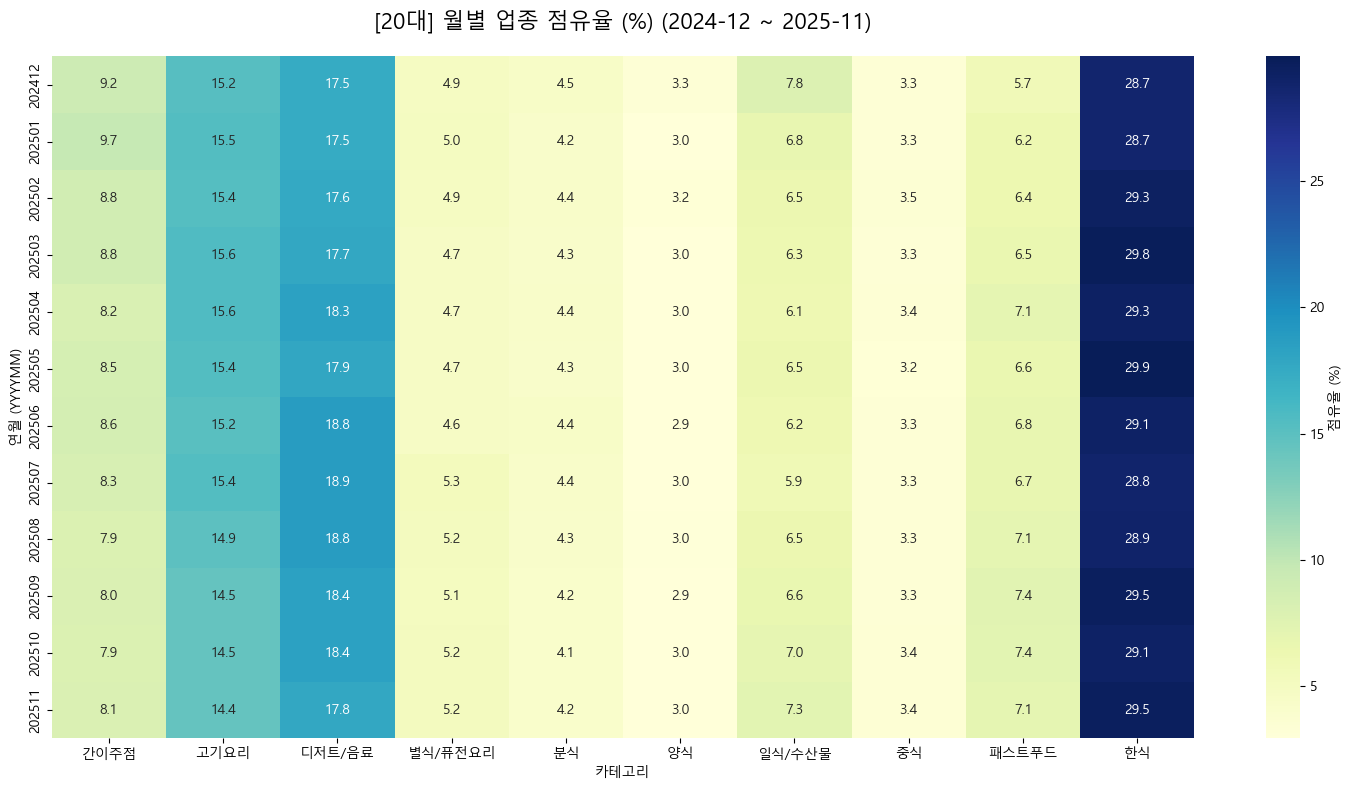

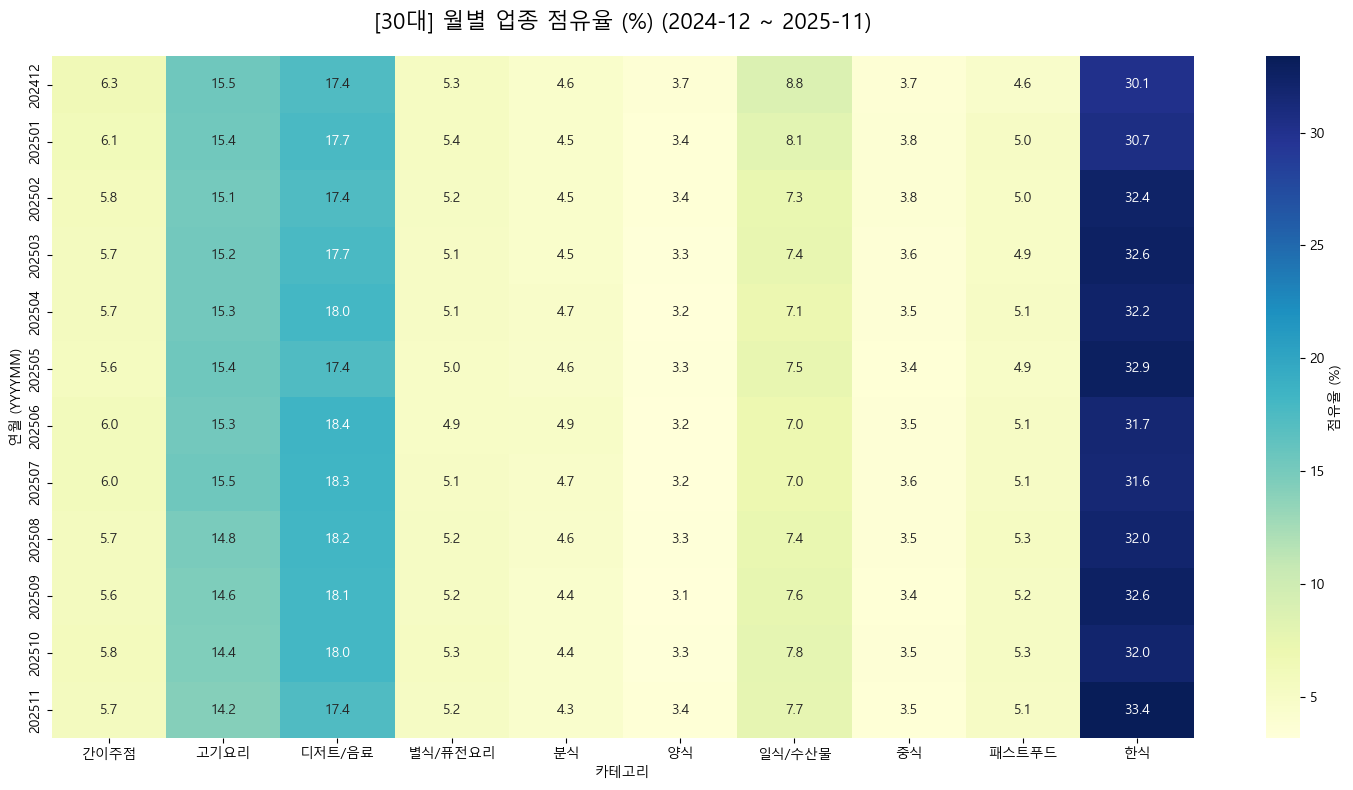

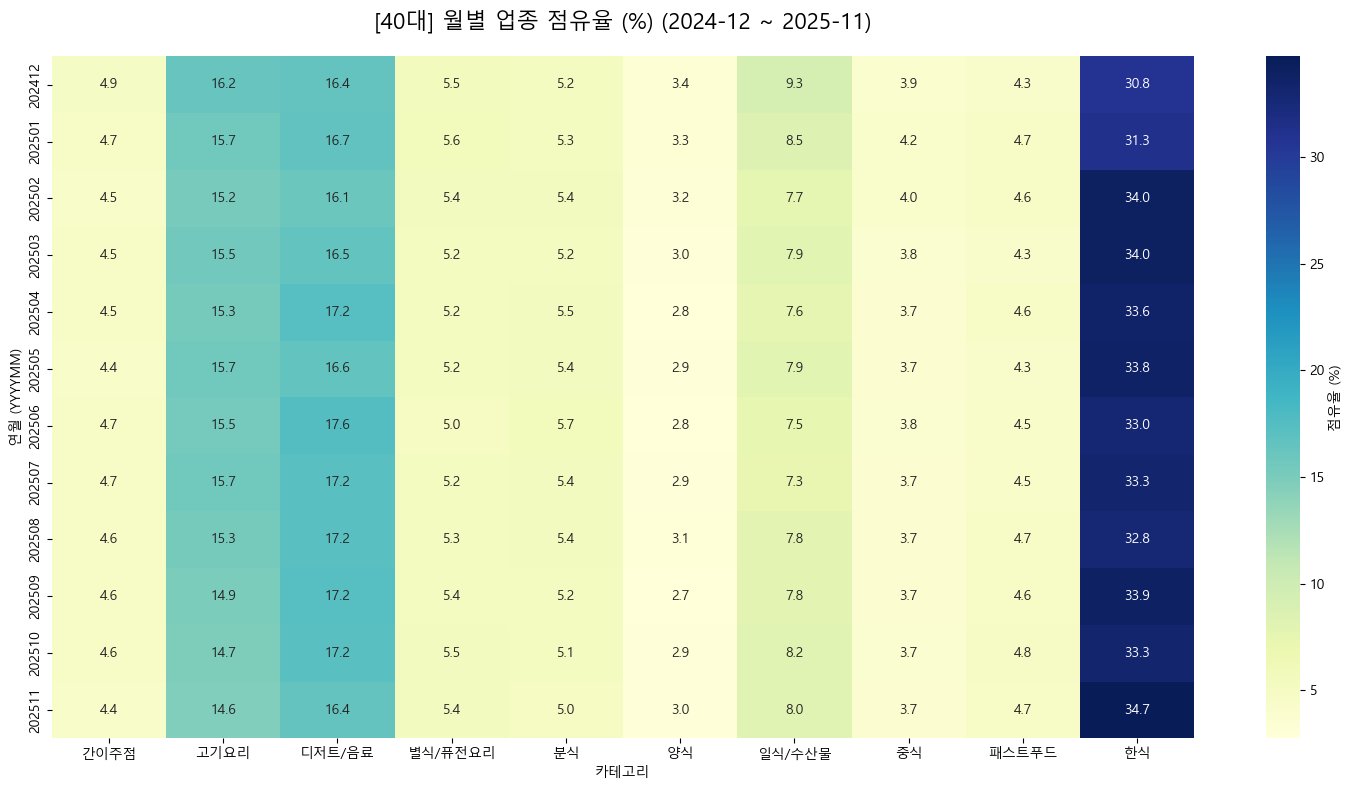

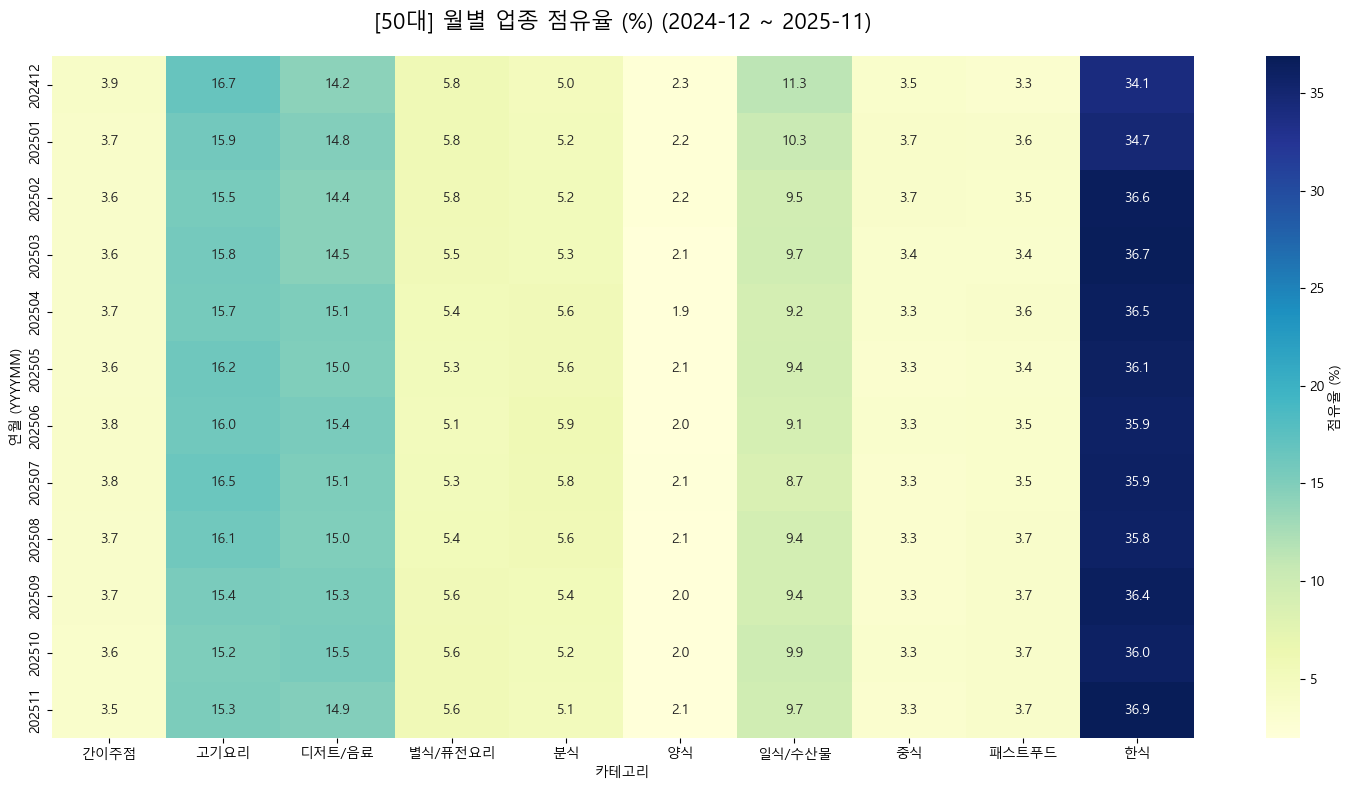

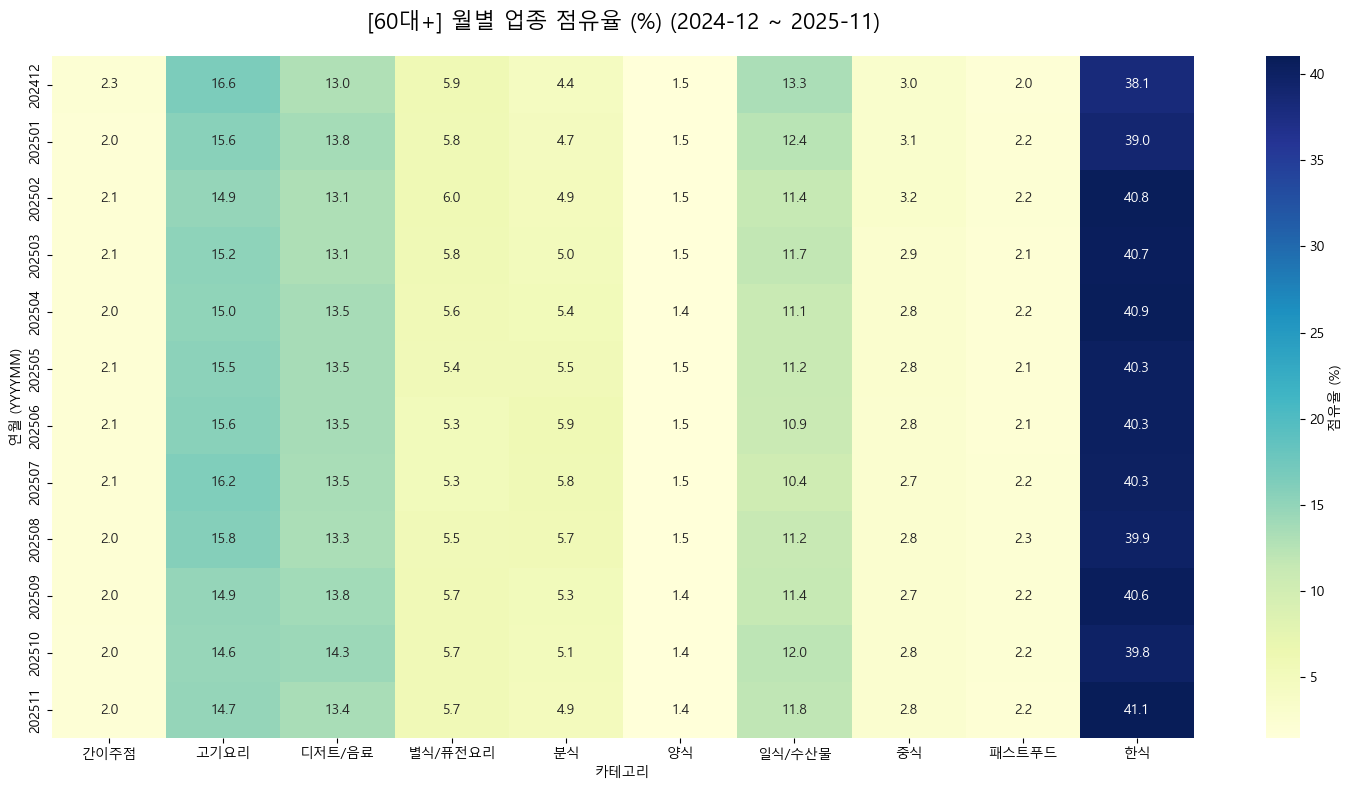

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 로드
df_age = pd.read_csv('../output/age_category_summary_202412_202511.csv')

# 🔥 YYYYMM 문자열 그대로 사용 (연도 + 월)
df_age['year_month'] = df_age['month'].astype(str)

# 분석 대상 세대
target_ages = ['20대', '30대', '40대', '50대', '60대+']
df_filtered = df_age[df_age['age_group'].isin(target_ages)].copy()

# 2. 연령대별 개별 Figure
for age in target_ages:
    df_sub = df_filtered[df_filtered['age_group'] == age]
    
    if df_sub.empty:
        print(f"{age} 데이터 없음 → 스킵")
        continue
    
    pivot = df_sub.pivot_table(
        index='year_month',                 # 🔥 연도 포함
        columns='card_tpbuz_nm_2',
        values='total_amt',
        aggfunc='mean'
    ).sort_index()
    
    share_table = pivot.div(pivot.sum(axis=1), axis=0) * 100
    
    plt.figure(figsize=(15, 8))
    sns.heatmap(
        share_table,
        annot=True,
        fmt='.1f',
        cmap='YlGnBu',
        cbar_kws={'label': '점유율 (%)'}
    )
    
    plt.title(f'[{age}] 월별 업종 점유율 (%) (2024-12 ~ 2025-11)', fontsize=16, pad=20)
    plt.ylabel('연월 (YYYYMM)')
    plt.xlabel('카테고리')
    plt.tight_layout()
    plt.show()


In [14]:
import pandas as pd
import glob
import os

# 1. 파일이 저장된 경로 설정 (파일들이 있는 폴더 경로를 입력하세요)
# 현재 작업 디렉토리에 있다면 './'를 사용합니다.
file_path = '../food' 

# 2. 202412.parquet ~ 202511.parquet 패턴의 모든 파일 목록 가져오기
# 파일명이 숫자로 시작하므로 아래와 같이 패턴을 잡을 수 있습니다.
# all_files = glob.glob(os.path.join(file_path, "*.parquet"))

# -------------------------------
# 3. Parquet 파일 필터링 (최근 1년)
# -------------------------------
files = sorted(glob.glob(os.path.join(file_path, "*.parquet")))

all_files = [
    f for f in files
    if "202412" <= os.path.basename(f).replace(".parquet", "") <= "202511"
]

if not all_files:
    raise ValueError("202412~202511 기간의 Parquet 파일이 없습니다.")

print(f"분석 대상 파일 수: {len(all_files)}")

# 3. 12개의 파일을 리스트로 읽어온 후 하나로 합치기
df_list = []
for filename in sorted(all_files):
    # 파일명에서 연월 정보를 추출하여 새로운 컬럼으로 추가하면 시계열 분석에 용이합니다.
    temp_df = pd.read_parquet(filename)
    # 예: '202412' 같은 파일명을 저장
    temp_df['source_file'] = os.path.basename(filename).split('.')[0] 
    df_list.append(temp_df)

# 최종 데이터프레임 생성
df = pd.concat(df_list, axis=0, ignore_index=True)

# 5. 전처리에 필요한 컬럼 타입 변환 (필요 시)
# 예를 들어 hour가 문자열이라면 숫자로 변환
if 'hour' in df.columns:
    df['hour'] = pd.to_numeric(df['hour'], errors='coerce')

# 2. 연령대 매핑 (2~6 -> 20s~60s+)
age_map = {2: '20대', 3: '30대', 4: '40대', 5: '50대', 6: '60대+'}
df['age_grp'] = df['age'].map(age_map)

# 3. 성별 매핑 (데이터에 따라 M/F 또는 1/2일 수 있으니 확인 후 적용)
# 만약 1:남, 2:여 형식이라면 아래 주석 해제 후 사용
# df['sex_grp'] = df['sex_cd'].map({1: 'Male', 2: 'Female'})
df['sex_grp'] = df['sex'] # 현재 데이터 형식이 M/F라면 그대로 유지

# 4. 데이터 확인
print(f"총 {len(all_files)}개의 파일을 읽어왔습니다.")
print(f"전체 데이터 행 수: {len(df):,}")
print(df.head())

분석 대상 파일 수: 12
총 12개의 파일을 읽어왔습니다.
전체 데이터 행 수: 41,881,356
     ta_ymd  admi_cty_no card_tpbuz_nm_2  hour sex  age  day     amt  cnt  \
0  20241201     41192510            간이주점     1   F    4    7   50152    2   
1  20241201     41192510            간이주점     1   F    5    7   67629    2   
2  20241201     41192510            간이주점     1   M    2    7  192553    2   
3  20241201     41192510            간이주점     1   M    3    7  144377    2   
4  20241201     41192510            간이주점     1   M    6    7   45593    2   

  source_file age_grp sex_grp  
0      202412     40대       F  
1      202412     50대       F  
2      202412     20대       M  
3      202412     30대       M  
4      202412    60대+       M  


In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

# ============================================================
# 한글 폰트 설정 (Windows)
# ============================================================
mpl.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

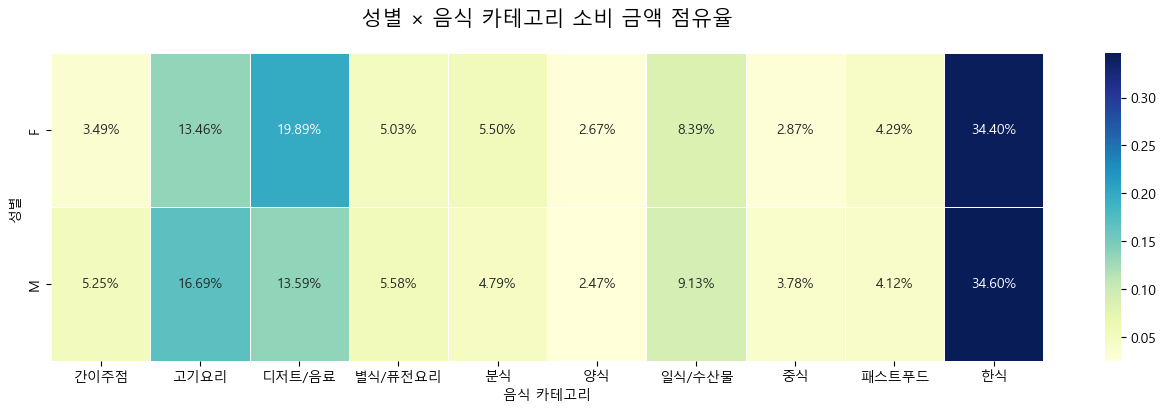

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 데이터 집계 (성별, 카테고리별 금액 합계)
gender_cat_amt = df.groupby(['sex', 'card_tpbuz_nm_2'])['amt'].sum().unstack()

# 2. 정규화 (성별 내에서 각 카테고리가 차지하는 비중으로 변환 - 추천)
# 이렇게 하면 남성/여성 각각의 총 소비 중 어떤 카테고리가 '비중'이 높은지 보입니다.
gender_cat_ratio = gender_cat_amt.div(gender_cat_amt.sum(axis=1), axis=0)

plt.figure(figsize=(16, 4))
sns.heatmap(gender_cat_ratio, annot=True, fmt=".2%", cmap="YlGnBu", linewidths=.5)
plt.title('성별 × 음식 카테고리 소비 금액 점유율', fontsize=15, pad=20)
plt.ylabel('성별')
plt.xlabel('음식 카테고리')
plt.show()

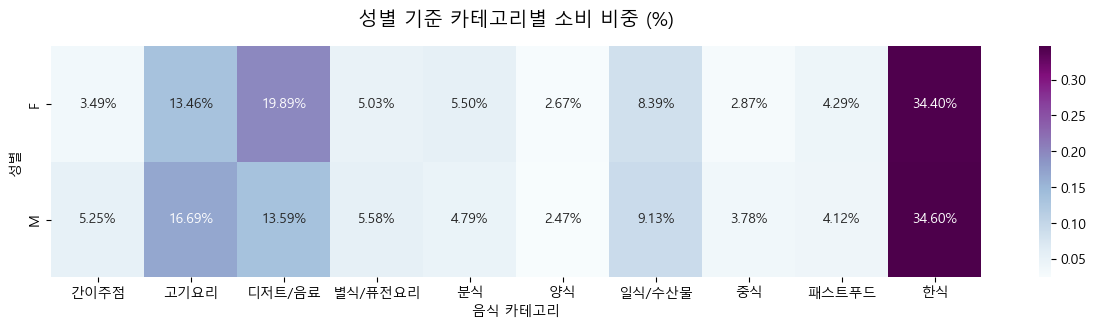

In [19]:
# 성별 내에서 각 카테고리가 차지하는 비중 계산
gender_heatmap = df.groupby(['sex_grp', 'card_tpbuz_nm_2'])['amt'].sum().unstack()
gender_heatmap_ratio = gender_heatmap.div(gender_heatmap.sum(axis=1), axis=0)

plt.figure(figsize=(15, 3))
sns.heatmap(gender_heatmap_ratio, annot=True, fmt=".2%", cmap="BuPu")
plt.title('성별 기준 카테고리별 소비 비중 (%)', fontsize=14, pad=15)
plt.ylabel('성별')
plt.xlabel('음식 카테고리')
plt.show()

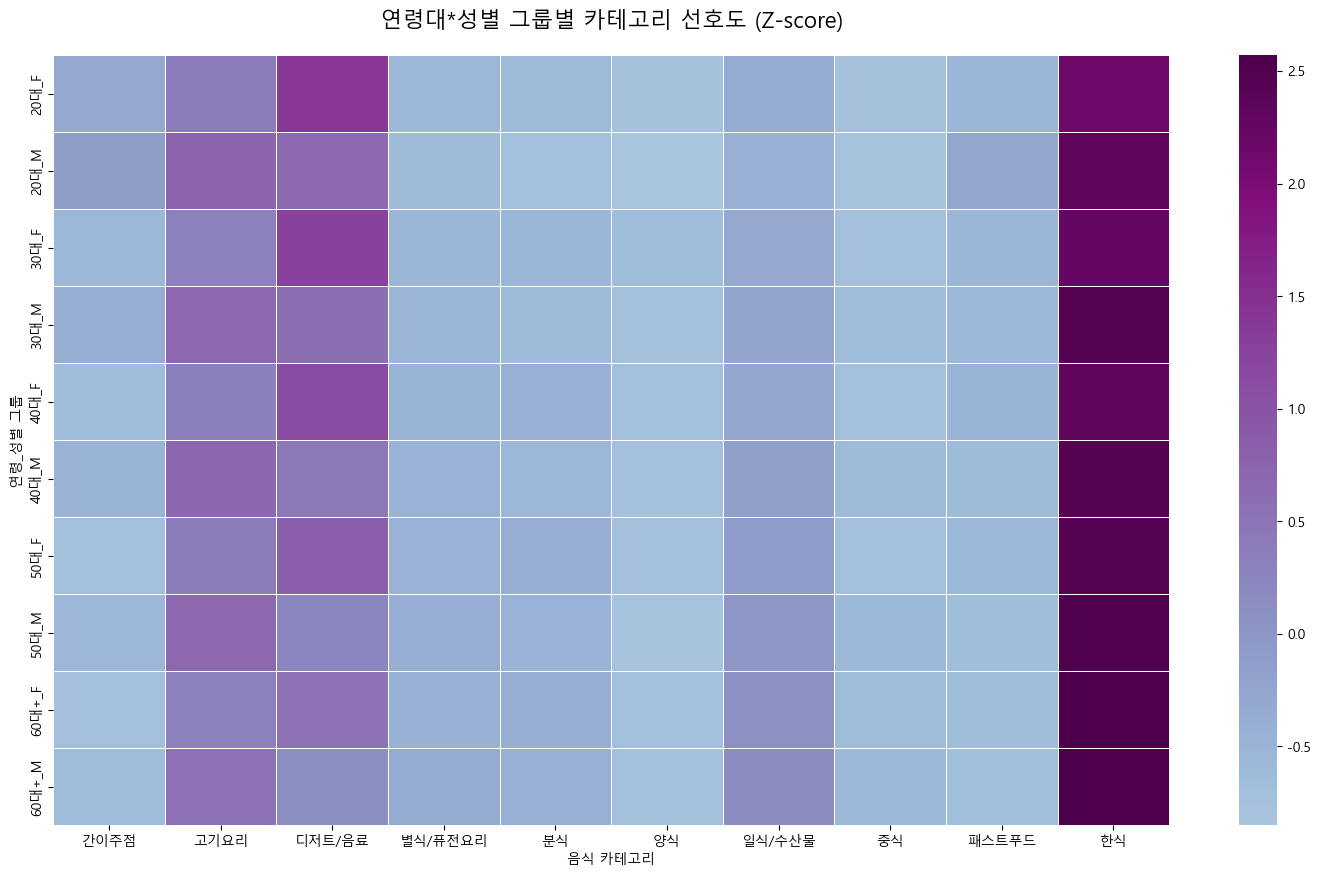

In [16]:
# 1. 연령_성별 결합 컬럼 생성
df['age_sex_grp'] = df['age_grp'] + "_" + df['sex_grp']

# 2. 그룹별/카테고리별 금액 집계
pivot_df = df.groupby(['age_sex_grp', 'card_tpbuz_nm_2'])['amt'].sum().unstack()

# 3. Z-score 계산 (행 단위 표준화: 해당 그룹 내에서 선호도 강조)
# 특정 집단이 '평균적으로' 어디에 더 많이 쓰는지 보여줌
zscore_df = pivot_df.apply(lambda x: (x - x.mean()) / x.std(), axis=1)

# 시각화 (인덱스 순서를 20s_F, 20s_M, 30s_F... 순으로 정렬)
zscore_df = zscore_df.sort_index()

plt.figure(figsize=(18, 10))
sns.heatmap(zscore_df, annot=False, cmap="BuPu", center=0, linewidths=.5)
plt.title('연령대*성별 그룹별 카테고리 선호도 (Z-score)', fontsize=16, pad=20)
plt.ylabel('연령_성별 그룹')
plt.xlabel('음식 카테고리')
plt.show()